# Combined workflow for Xv and q prediction

This notebook simulates a Cartesian grid of Jang bioreactor experiments, then trains two neural networks:
1. A time-conditioned model to predict viable cell density $X_v(t)$.
2. A time-conditioned model to predict reaction fluxes $q(t)$ for a reduced stoichiometric system.

Both models share the same synthetic dataset and time features, and the final section compares reconstructed
concentration trajectories using (a) Jang's kinetic model, (b) an identified "perfect" $q(t)$ from windowed
ridge regression, and (c) the neural network $q$ predictions.

In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from utils import bioreactor_jang

# ---------------- Global config ----------------
CFG = {
    "seed": 7,
    "T_sim": 200.0,
    "dt": 1.0,
    "n_freq": 5,
    "use_poly": True,
    "val_frac": 0.2,
    "test_frac": 0.2,
}

np.random.seed(CFG["seed"])
tf.random.set_seed(CFG["seed"])

# Stoichiometric matrix S (5 extracellular species × 2 pseudo-reactions)
species_names = ["glc", "gln", "lac", "amm", "Ab"]
S = np.array([
    [-2.44803, -3.50990],  # glc
    [-1.50037, -0.28841],  # gln
    [ 3.40522,  0.00000],  # lac
    [ 2.00074, -0.42317],  # amm
    [ 0.00000,  1.00000],  # Ab
], dtype=float)

# ---- Ab units handling (Option A): keep Ab in mg/L everywhere ----
# Your Jang simulator outputs Ab in mg/L. The reduced stoichiometric matrix S is in mol-based units.
# To make dC/dt consistent in mg/L for Ab, scale ONLY the Ab row of S by MW (mg/mmol).
USE_AB_MG_L = True
MW_AB_mg_per_mmol = 150_000.0  # 150 kDa antibody
AB_ROW = species_names.index("Ab")

S_use = S.copy()
if USE_AB_MG_L:
    S_use[AB_ROW, :] = S_use[AB_ROW, :] * MW_AB_mg_per_mmol
r = S.shape[1]  # number of fluxes
m = S.shape[0]  # number of extracellular species


In [2]:

# ---------------- Time features ----------------
def fourier_time_features(t, T_sim, n_freq=8, add_poly=True):
    """Return time features of shape (T, 2*n_freq [+3]) in float32."""
    s = (t / float(T_sim)).astype(np.float32)                 # scaled to [0, 1]
    k = np.arange(1, n_freq + 1, dtype=np.float32)[None, :]   # (1, F)
    arg = (2.0 * np.pi * s[:, None] * k).astype(np.float32)   # (T, F)
    F = np.concatenate([np.sin(arg), np.cos(arg)], axis=1)    # (T, 2F)
    if add_poly:
        poly = np.stack([s, s**2, s**3], axis=1)              # (T, 3)
        F = np.concatenate([F, poly], axis=1)                 # (T, 2F + 3)
    return F.astype(np.float32)


In [3]:

# ---------------- Jang RHS in physical units ----------------
def jang_rhs_phys(t, y_phys):
    """Wrapper around utils.bioreactor_jang using physical ordering:
    y_phys = [glc, gln, lac, amm, Ab, Xv].
    bioreactor_jang expects [Xv, glc, gln, lac, amm, Ab] and returns the same order.
    """
    C_glc, C_gln, C_lac, C_amm, C_Ab, C_X = y_phys

    # Reorder for the original Jang implementation: [Xv, glc, gln, lac, amm, Ab]
    y_jang = np.array([C_X, C_glc, C_gln, C_lac, C_amm, C_Ab], dtype=float)
    dC_X_dt, dC_glc_dt, dC_gln_dt, dC_lac_dt, dC_amm_dt, dC_Ab_dt = bioreactor_jang(t, y_jang)

    # Reorder derivatives back to physical ordering [glc, gln, lac, amm, Ab, Xv]
    return np.array([dC_glc_dt, dC_gln_dt, dC_lac_dt, dC_amm_dt, dC_Ab_dt, dC_X_dt], dtype=float)


def simulate_one(y0_phys, t_eval):
    """Simulate one experiment using Jang's model.

    y0_phys: array-like of length 6 in order [glc0, gln0, lac0, amm0, Ab0, Xv0].
    Returns:
        C:  (5, T) concentrations [glc, gln, lac, amm, Ab]
        Xv: (T,)   viable cell density
    """
    sol = solve_ivp(
        fun=jang_rhs_phys,
        t_span=(float(t_eval[0]), float(t_eval[-1])),
        y0=y0_phys.astype(float),
        t_eval=t_eval.astype(float),
        method="BDF",
        rtol=1e-6,
        atol=1e-9,
        max_step=2.0,
    )
    Y = sol.y  # (6, T) in [glc, gln, lac, amm, Ab, Xv]
    C = Y[:5, :].astype(np.float32)
    Xv = np.maximum(Y[5, :], 0.0).astype(np.float32)
    return C, Xv


In [4]:

# ---------------- Build Cartesian grid of initial conditions ----------------
def build_cartesian_grid():
    """Initial conditions used to generate the synthetic dataset.

    glc, gln in [5, 35] mM, linearly spaced.
    lac, amm, Ab start at 0 (typical for fresh inoculation).
    Xv0 between 1e7 and 1e8 cells/L.
    """
    C_glc_list = np.linspace(5.0, 35.0, 15)   # mM
    C_gln_list = np.linspace(5.0, 35.0, 15)   # mM
    C_lac_list = [0.0]                        # mM
    C_amm_list = [0.0]                        # mM
    C_Ab_list  = [0.0]                        # model units
    Xv0_list   = np.linspace(1e7, 1e8, 10)    # cells/L

    grid = []
    for glc0 in C_glc_list:
        for gln0 in C_gln_list:
            for lac0 in C_lac_list:
                for amm0 in C_amm_list:
                    for Ab0 in C_Ab_list:
                        for Xv0 in Xv0_list:
                            grid.append([glc0, gln0, lac0, amm0, Ab0, Xv0])
    return np.array(grid, dtype=np.float32)


# Time grid and features shared by both networks
T_sim, dt = CFG["T_sim"], CFG["dt"]
t_eval = np.linspace(0.0, T_sim, int(T_sim / dt) + 1, dtype=np.float32)
F_time_full = fourier_time_features(
    t_eval,
    T_sim,
    n_freq=CFG["n_freq"],
    add_poly=CFG["use_poly"],
)

# Simulate all experiments on the Cartesian grid
all_y0 = build_cartesian_grid()              # (Nexp, 6)
Nexp   = all_y0.shape[0]
print(f"Number of experiments: {Nexp}")

all_C  = []
all_Xv = []
for i, y0 in enumerate(all_y0):
    C_i, Xv_i = simulate_one(y0, t_eval)
    all_C.append(C_i)
    all_Xv.append(Xv_i)
    if (i + 1) % max(1, Nexp // 10) == 0:
        print(f"  simulated {i+1}/{Nexp}")

all_C  = np.stack(all_C, axis=0)   # (Nexp, m, T)
all_Xv = np.stack(all_Xv, axis=0)  # (Nexp, T)

# convenience views of initial states
all_C0  = all_C[:, :, 0]           # (Nexp, m)
all_Xv0 = all_Xv[:, 0]             # (Nexp,)

print("all_C:", all_C.shape, " all_Xv:", all_Xv.shape)


Number of experiments: 2250
  simulated 225/2250
  simulated 450/2250
  simulated 675/2250
  simulated 900/2250
  simulated 1125/2250
  simulated 1350/2250
  simulated 1575/2250
  simulated 1800/2250
  simulated 2025/2250
  simulated 2250/2250
all_C: (2250, 5, 201)  all_Xv: (2250, 201)


In [5]:

# ---------------- Helper: deterministic experiment split ----------------
def split_experiments(Nexp, val_frac, test_frac, seed):
    exps = np.arange(Nexp)
    train_exps, test_exps = train_test_split(
        exps,
        test_size=test_frac,
        random_state=seed,
        shuffle=True,
    )
    left = np.setdiff1d(exps, test_exps)
    train_exps2, val_exps = train_test_split(
        left,
        test_size=val_frac / (1.0 - test_frac),
        random_state=seed,
        shuffle=True,
    )
    return np.sort(train_exps2), np.sort(val_exps), np.sort(test_exps)

train_exps, val_exps, test_exps = split_experiments(
    Nexp,
    CFG["val_frac"],
    CFG["test_frac"],
    CFG["seed"],
)
print("Train exps:", train_exps.shape, "Val exps:", val_exps.shape, "Test exps:", test_exps.shape)


Train exps: (1350,) Val exps: (450,) Test exps: (450,)


In [6]:

# ============================================================
# Part A: Time-conditioned neural network for Xv(t)
# ============================================================

# 1) Build sequence datasets (IC + time features -> Xv trajectory)

def fit_minmax_xv(X0_tr, Xv_tr):
    """Train-only min–max scaling for X0 and Xv."""
    x_min = X0_tr.min(axis=0, keepdims=True)
    x_max = X0_tr.max(axis=0, keepdims=True)
    x_rng = x_max - x_min + 1e-12

    y_min = Xv_tr.min(axis=(0, 1), keepdims=True)  # scalar stored as (1,1)
    y_max = Xv_tr.max(axis=(0, 1), keepdims=True)
    y_rng = y_max - y_min + 1e-12
    return x_min, x_rng, y_min, y_rng


def norm_xv_inputs(X0, x_min, x_rng):
    return (X0 - x_min) / x_rng


def norm_xv_targets(Xv, y_min, y_rng):
    return (Xv - y_min) / y_rng


def denorm_xv(Xv_s, y_min, y_rng):
    return Xv_s * y_rng + y_min


# gather ICs and trajectories per split
X0_tr = all_y0[train_exps]   # (Ntr, 6)
X0_va = all_y0[val_exps]
X0_te = all_y0[test_exps]

Xv_tr = all_Xv[train_exps]   # (Ntr, T)
Xv_va = all_Xv[val_exps]
Xv_te = all_Xv[test_exps]

x_min_xv, x_rng_xv, y_min_xv, y_rng_xv = fit_minmax_xv(X0_tr, Xv_tr)

# Build per-time inputs: [scaled ICs, time features]
T = t_eval.shape[0]
F = F_time_full.shape[1]
print("T:", T, " F_time dims:", F)

def build_xv_features(X0, F_time, x_min, x_rng):
    N = X0.shape[0]
    X0_s = norm_xv_inputs(X0, x_min, x_rng)        # (N, 6)
    X0_rep = np.repeat(X0_s[:, None, :], T, axis=1)   # (N, T, 6)
    F_rep  = np.repeat(F_time[None, :, :], N, axis=0) # (N, T, F)
    return np.concatenate([X0_rep, F_rep], axis=2)    # (N, T, 6+F)

X_tr_seq = build_xv_features(X0_tr, F_time_full, x_min_xv, x_rng_xv)
X_va_seq = build_xv_features(X0_va, F_time_full, x_min_xv, x_rng_xv)
X_te_seq = build_xv_features(X0_te, F_time_full, x_min_xv, x_rng_xv)

Y_tr_seq = norm_xv_targets(Xv_tr[..., None], y_min_xv, y_rng_xv)  # (Ntr,T,1)
Y_va_seq = norm_xv_targets(Xv_va[..., None], y_min_xv, y_rng_xv)
Y_te_seq = norm_xv_targets(Xv_te[..., None], y_min_xv, y_rng_xv)

print("X_tr_seq:", X_tr_seq.shape, " Y_tr_seq:", Y_tr_seq.shape)


T: 201  F_time dims: 13
X_tr_seq: (1350, 201, 19)  Y_tr_seq: (1350, 201, 1)


In [7]:

# 2) Define and train the Xv model

def build_xv_dnn(T, Din, widths=(256, 384, 384, 256, 128), dropout=0.1, wd=1e-4):
    x_in = keras.Input(shape=(T, Din), name="x_in_xv")
    h = x_in
    for i, w in enumerate(widths):
        h = layers.Dense(
            w,
            activation="gelu",
            name=f"dense_xv_{i}"
        )(h)
        if dropout > 0.0:
            h = layers.Dropout(dropout, name=f"dropout_xv_{i}")(h)
    y_out = layers.Dense(1, name="Xv_hat")(h)
    return keras.Model(inputs=x_in, outputs=y_out, name="xv_time_conditioned_dnn")


Din_xv = X_tr_seq.shape[2]
model_xv = build_xv_dnn(T, Din_xv, dropout=0)
model_xv.summary()

model_xv.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="mse",
    metrics=["mse"],
)

cbs = [
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=10, min_lr=1e-5, verbose=1),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True, verbose=1),
]

hist_xv = model_xv.fit(
    X_tr_seq, Y_tr_seq,
    validation_data=(X_va_seq, Y_va_seq),
    epochs=150,
    batch_size=128,
    callbacks= cbs,
    verbose=1,
)


Model: "xv_time_conditioned_dnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ x_in_xv (InputLayer)            │ (None, 201, 19)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_xv_0 (Dense)              │ (None, 201, 256)       │         5,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_xv_1 (Dense)              │ (None, 201, 384)       │        98,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_xv_2 (Dense)              │ (None, 201, 384)       │       147,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_xv_3 (Dense)              │ (None, 201, 256)       │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_xv_4 (Dense)              │ (None, 201, 128)       │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Xv_hat (Dense)                  │ (None, 201, 1)         │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 383,233 (1.46 MB)

 Trainable params: 383,233 (1.46 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - loss: 0.0279 - mse: 0.0279 - val_loss: 0.0117 - val_mse: 0.0117 - learning_rate: 0.0010
Epoch 2/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - loss: 0.0105 - mse: 0.0105 - val_loss: 0.0092 - val_mse: 0.0092 - learning_rate: 0.0010
Epoch 3/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - loss: 0.0086 - mse: 0.0086 - val_loss: 0.0075 - val_mse: 0.0075 - learning_rate: 0.0010
Epoch 4/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - loss: 0.0070 - mse: 0.0070 - val_loss: 0.0052 - val_mse: 0.0052 - learning_rate: 0.0010
Epoch 5/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - loss: 0.0055 - mse: 0.0055 - val_loss: 0.0049 - val_mse: 0.0049 - learning_rate: 0.0010
Epoch 6/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - loss: 0.0051 - mse: 0.0051 - val_loss: 0.0050 - val_mse: 0.0050 - learning_rate: 0.0010
Epoch 7/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - loss: 0.0049 - mse: 0.0049 - val_loss: 0.0046 - val_mse: 0.0046 - learning_rate: 0.0010
Epoch 8/150
1

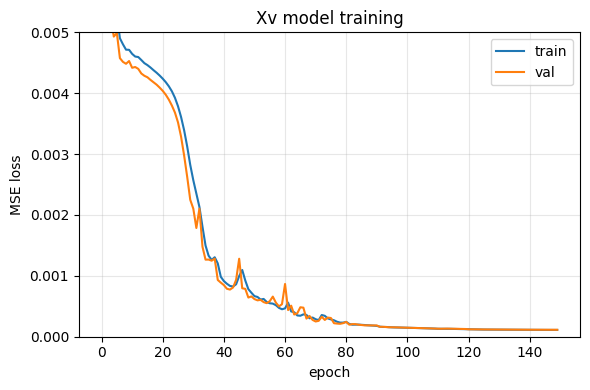

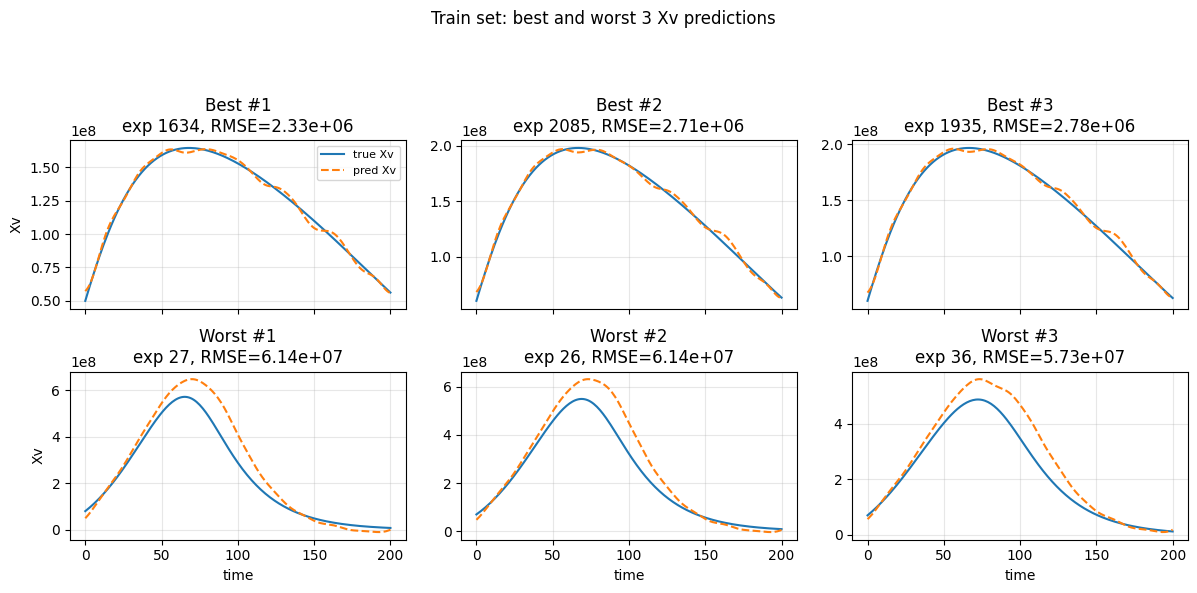

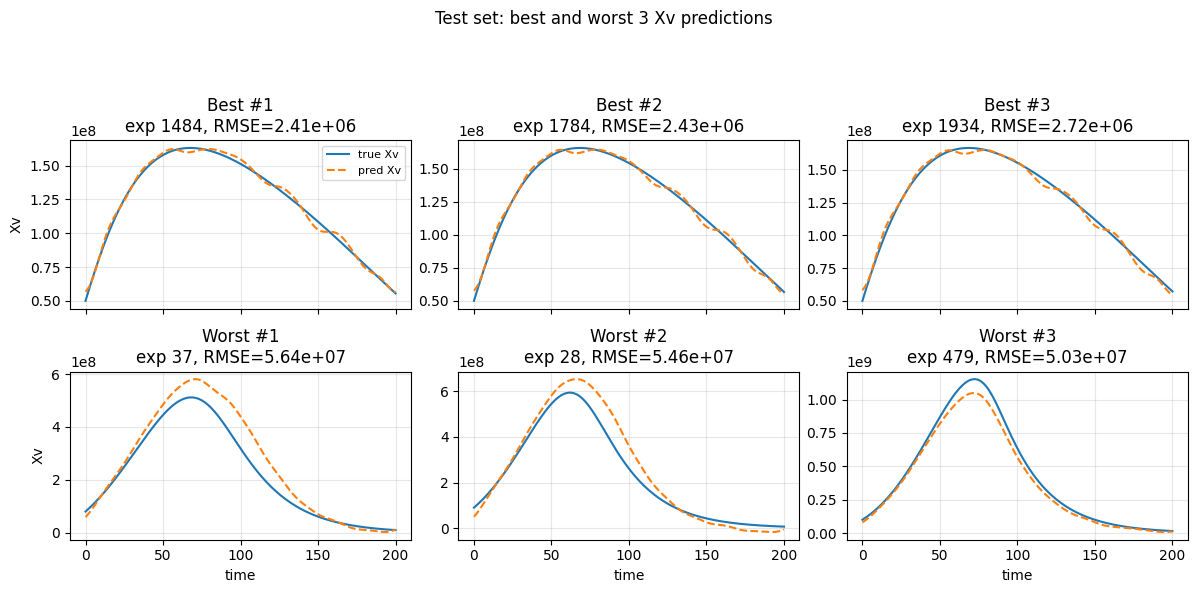

In [8]:
# 3) Visualise Xv training curves

plt.figure(figsize=(6,4))
plt.plot(hist_xv.history["loss"], label="train")
plt.plot(hist_xv.history["val_loss"], label="val")
plt.xlabel("epoch")
plt.ylabel("MSE loss")
plt.title("Xv model training")
plt.ylim(top = 0.005, bottom=0)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 4) Best / worst Xv trajectories on train & test (per-experiment RMSE)

def compute_rmse_per_seq(y_true, y_pred):
    """RMSE over time per sequence (shape: (N,T))."""
    return np.sqrt(np.mean((y_true - y_pred) ** 2, axis=1))

def plot_best_worst_xv(split="test", N=3):
    """
    Plot best and worst N Xv trajectories for a given split
    (split in {"train","test"}).
    """
    if split == "train":
        X_seq = X_tr_seq
        Xv_true = Xv_tr
        exps = train_exps
        title_prefix = "Train"
    else:
        X_seq = X_te_seq
        Xv_true = Xv_te
        exps = test_exps
        title_prefix = "Test"

    # Predict for this split
    Xv_pred_s = model_xv.predict(X_seq, verbose=0)[:, :, 0]  # (N,T)
    Xv_pred   = denorm_xv(Xv_pred_s, y_min_xv, y_rng_xv)

    # RMSE per sequence
    rmse = compute_rmse_per_seq(Xv_true, Xv_pred)

    # Indices of best and worst N
    order = np.argsort(rmse)
    best_idx  = order[:N]
    worst_idx = order[-N:][::-1]  # reverse so worst is highest RMSE

    # 2 x N subplots: first row = best, second row = worst
    ncols = N
    fig, axes = plt.subplots(2, ncols, figsize=(4*ncols, 6), sharex=True)
    axes = np.atleast_2d(axes)

    rows_info = [
        ("Best",  best_idx),
        ("Worst", worst_idx),
    ]

    for row_idx, (row_label, idxs) in enumerate(rows_info):
        for col_idx, seq_idx in enumerate(idxs):
            ax = axes[row_idx, col_idx]
            ax.plot(t_eval, Xv_true[seq_idx], label="true Xv")
            ax.plot(t_eval, Xv_pred[seq_idx], "--", label="pred Xv")
            ax.set_title(
                f"{row_label} #{col_idx+1}\n"
                f"exp {int(exps[seq_idx])}, RMSE={rmse[seq_idx]:.2e}"
            )
            ax.grid(alpha=0.3)
            if row_idx == 1:
                ax.set_xlabel("time")
            if col_idx == 0:
                ax.set_ylabel("Xv")

    # One legend for all
    axes[0,0].legend(fontsize=8)
    fig.suptitle(f"{title_prefix} set: best and worst {N} Xv predictions", y=0.98)
    fig.tight_layout(rect=[0, 0, 1, 0.94])
    plt.show()

# Example: show top 3 best/worst for train and test
plot_best_worst_xv(split="train", N=3)
plot_best_worst_xv(split="test",  N=3)


In [9]:

# ============================================================
# Part B: Identification of q(t) via windowed ridge, and NN for q
# ============================================================

# 1) Finite differences and standard (unweighted) windowed ridge
lam = 1e-4   # ridge regularisation
Wlen = 5     # window length in time points

def finite_diff(C, t_grid):
    dt = np.diff(t_grid)                        # (T-1,)
    return (C[:, 1:] - C[:, :-1]) / dt         # (m, T-1)

# Normalise concentrations species-wise to reduce scale imbalances
C_scale = np.max(np.abs(all_C), axis=(0, 2))   # (m,)
C_scale[C_scale == 0.0] = 1.0
S_tilde = np.diag(1.0 / C_scale) @ S_use          # (m, r)

def windowed_ridge_q(Xv_vec, S_mat, dC_tilde, lam=1e-4, win_len=5):
    """Standard windowed ridge: solve Xv*S*q ≈ dC_tilde over a short time window."""
    m_, Tp = dC_tilde.shape
    r_ = S_mat.shape[1]
    q = np.zeros((r_, Tp), dtype=float)
    I = np.eye(r_)

    for k in range(Tp):
        kend = min(Tp, k + win_len)
        rows, rhs = [], []
        for kk in range(k, kend):
            Ak = Xv_vec[kk] * S_mat            # (m, r)
            bk = dC_tilde[:, kk]              # (m,)
            rows.append(Ak)
            rhs.append(bk)
        A = np.vstack(rows)                   # (win_len*m, r)
        b = np.concatenate(rhs)               # (win_len*m,)
        ATA = A.T @ A + lam * I
        ATb = A.T @ b
        q[:, k] = np.linalg.solve(ATA, ATb)
    return q   # (r, T-1)


In [10]:

# 2) Build supervised dataset for q: [C0, Xv0, Xv(t), time features] -> q(t)

F_time_q = fourier_time_features(
    t_eval[:-1],
    T_sim,
    n_freq=CFG["n_freq"],
    add_poly=CFG["use_poly"],
)

Xp_list, yp_list, meta = [], [], []  # meta stores (exp_id, time_index)

for e in range(Nexp):
    C   = all_C[e]          # (m, T) physical units
    Xv  = all_Xv[e]         # (T,)
    C0  = all_C0[e]         # (m,)
    Xv0 = all_Xv0[e]        # scalar

    # work with dimensionless concentrations
    C_tilde  = C / C_scale[:, None]               # (m, T)
    dC_tilde = finite_diff(C_tilde, t_eval)       # (m, T-1)

    q_hat = windowed_ridge_q(
        Xv_vec=Xv[:-1],
        S_mat=S_tilde,
        dC_tilde=dC_tilde,
        lam=lam,
        win_len=Wlen,
    )  # (r, T-1)

    Tm1 = t_eval.shape[0] - 1

    C0_rep  = np.repeat(C0[None, :],  Tm1, axis=0)   # (T-1, m)
    Xv0_rep = np.repeat([[Xv0]],       Tm1, axis=0)  # (T-1, 1)
    Xv_t    = Xv[:-1][:, None]                       # (T-1, 1)

    X_e = np.concatenate([C0_rep, Xv0_rep, Xv_t, F_time_q], axis=1)  # (T-1, Din_q)
    y_e = q_hat.T                                                   # (T-1, r)

    Xp_list.append(X_e)
    yp_list.append(y_e)
    meta.extend([(e, k) for k in range(Tm1)])

X_all_q = np.vstack(Xp_list)   # (#samples, Din_q)
y_all_q = np.vstack(yp_list)   # (#samples, r)
meta    = np.array(meta)
Din_q   = X_all_q.shape[1]
print("X_all_q:", X_all_q.shape, " y_all_q:", y_all_q.shape, " Din_q:", Din_q, " r:", r)

exp_ids = meta[:, 0].astype(int)

mask_tr_q = np.isin(exp_ids, train_exps)
mask_va_q = np.isin(exp_ids, val_exps)
mask_te_q = np.isin(exp_ids, test_exps)

X_tr_q, y_tr_q = X_all_q[mask_tr_q], y_all_q[mask_tr_q]
X_va_q, y_va_q = X_all_q[mask_va_q], y_all_q[mask_va_q]
X_te_q, y_te_q = X_all_q[mask_te_q], y_all_q[mask_te_q]

idx_test_global = np.where(mask_te_q)[0]                # indices in full dataset
global_to_test = -np.ones_like(exp_ids, dtype=int)  # init with -1
global_to_test[idx_test_global] = np.arange(idx_test_global.size)


print(f"Train {X_tr_q.shape} / Val {X_va_q.shape} / Test {X_te_q.shape}")


X_all_q: (450000, 20)  y_all_q: (450000, 2)  Din_q: 20  r: 2
Train (270000, 20) / Val (90000, 20) / Test (90000, 20)


In [11]:
# 3) Scale inputs X and outputs y for q-model
#    This block mirrors the scaling strategy used in the standalone q_pred workflow:
#      - X: per-feature min–max on TRAIN ONLY
#      - q: per-flux robust scale -> min–max (with a small margin) on TRAIN ONLY

def fit_minmax_X(X):
    xmin = X.min(axis=0, keepdims=True)
    xmax = X.max(axis=0, keepdims=True)
    xrng = xmax - xmin + 1e-12
    return xmin, xrng

def norm_X(X, xmin, xrng):
    return (X - xmin) / xrng

# --- X scaling (train-only) ---
x_min_q, x_rng_q = fit_minmax_X(X_tr_q)
X_tr_q_s = norm_X(X_tr_q, x_min_q, x_rng_q)
X_va_q_s = norm_X(X_va_q, x_min_q, x_rng_q)
X_te_q_s = norm_X(X_te_q, x_min_q, x_rng_q)

# --- q scaling (train-only) ---
eps = 1e-12

# 1) robust scale so each q_j is O(1)
# use 95th percentile of |q| to reduce sensitivity to outliers
q_scale = 1.0 / (np.percentile(np.abs(y_tr_q), 95, axis=0, keepdims=True) + eps)  # (1,r)

y_tr_scaled = y_tr_q * q_scale
y_va_scaled = y_va_q * q_scale
y_te_scaled = y_te_q * q_scale

# 2) min–max to [margin, 1-margin] (again using train-only bounds)
ymin = y_tr_scaled.min(axis=0, keepdims=True)
ymax = y_tr_scaled.max(axis=0, keepdims=True)
yscale = (ymax - ymin) + eps

margin = 1e-3

def scale_q(y_phys):
    z = (y_phys * q_scale - ymin) / yscale          # nominal [0,1]
    return z * (1.0 - 2.0*margin) + margin          # [margin, 1-margin]

def unscale_q(y_s):
    z0 = (y_s - margin) / (1.0 - 2.0*margin)        # back to [0,1]
    return (z0 * yscale + ymin) / q_scale           # physical q

y_tr_q_s = scale_q(y_tr_q)
y_va_q_s = scale_q(y_va_q)
y_te_q_s = scale_q(y_te_q)

print("q_scale (per flux):", q_scale.ravel())
print("ymin/yscale (scaled):", ymin.ravel(), yscale.ravel())
print("TRAIN q stats (physical):")
for j in range(y_tr_q.shape[1]):
    qj = y_tr_q[:, j]
    print(f"  q{j+1}: min={qj.min():.3e}, max={qj.max():.3e}, med={np.median(qj):.3e}, p95={np.percentile(qj,95):.3e}")


q_scale (per flux): [9.80601086e+08 9.96906521e+11]
ymin/yscale (scaled): [1.22261426e-03 3.79826706e-05] [1.33827375e+01 3.10076023e-03]
TRAIN q stats (physical):
  q1: min=1.247e-12, max=1.365e-08, med=9.386e-11, p95=1.019e-09
  q2: min=3.810e-17, max=3.148e-15, med=2.812e-15, p95=3.103e-15


In [12]:

# 4) Define and train the q model

def build_q_dnn(Din, widths=(256, 384, 384, 256, 128), dropout=0.1):
    x_in = keras.Input(shape=(Din,), name="x_in_q")
    h = x_in
    for i, w in enumerate(widths):
        h = layers.Dense(
            w,
            activation="gelu",
            name=f"dense_q_{i}"
        )(h)
        if dropout > 0.0:
            h = layers.Dropout(dropout, name=f"dropout_q_{i}")(h)
    y_out = layers.Dense(r, name="q_hat")(h)
    return keras.Model(inputs=x_in, outputs=y_out, name="q_time_conditioned_dnn")


model_q = build_q_dnn(Din_q, dropout=0.0)
model_q.summary()

model_q.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="mse",
    metrics=["mse"]
)

cb_early_q = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=20,
    restore_best_weights=True,
    verbose=1,
)

hist_q = model_q.fit(
    X_tr_q_s, y_tr_q_s,
    validation_data=(X_va_q_s, y_va_q_s),
    epochs=300,
    batch_size=1024,
    callbacks=[cb_early_q],
    verbose=1,
)


Model: "q_time_conditioned_dnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ x_in_q (InputLayer)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_q_0 (Dense)               │ (None, 256)            │         5,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_q_1 (Dense)               │ (None, 384)            │        98,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_q_2 (Dense)               │ (None, 384)            │       147,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_q_3 (Dense)               │ (None, 256)            │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_q_4 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ q_hat (Dense)                   │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 383,618 (1.46 MB)

 Trainable params: 383,618 (1.46 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/300
264/264 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - loss: 0.0338 - mse: 0.0338 - val_loss: 0.0047 - val_mse: 0.0047
Epoch 2/300
264/264 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - loss: 0.0033 - mse: 0.0033 - val_loss: 0.0016 - val_mse: 0.0016
Epoch 3/300
264/264 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - loss: 0.0011 - mse: 0.0011 - val_loss: 0.0013 - val_mse: 0.0013
Epoch 4/300
264/264 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - loss: 7.2883e-04 - mse: 7.2883e-04 - val_loss: 4.4215e-04 - val_mse: 4.4215e-04
Epoch 5/300
264/264 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - loss: 5.1810e-04 - mse: 5.1810e-04 - val_loss: 3.5876e-04 - val_mse: 3.5876e-04
Epoch 6/300
264/264 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - loss: 3.9070e-04 - mse: 3.9070e-04 - val_loss: 2.9814e-04 - val_mse: 2.9814e-04
Epoch 7/300
264/264 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 3.3550e-04 - mse: 3.3550e-04 - val_loss: 3.5722e-04 - val_mse: 3.5722e-04
Epoch 8/300
264/264 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - loss: 3.0560e-04 - mse: 3.0560e-0

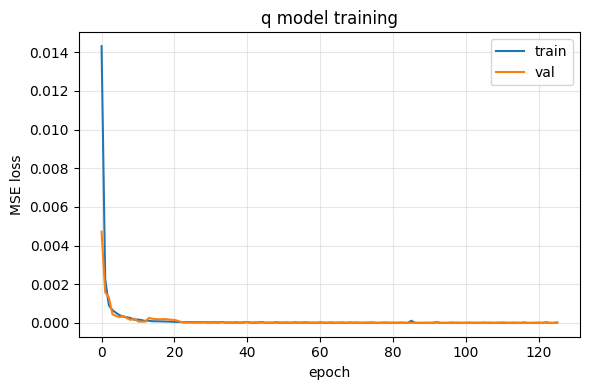

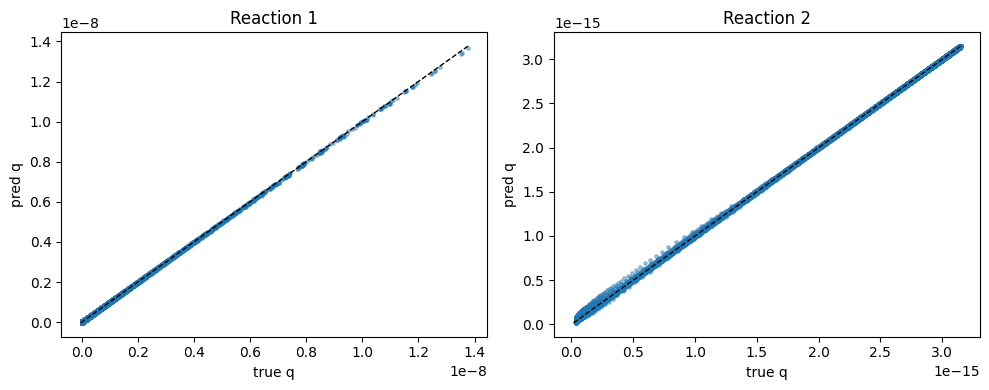

Best experiments (q RMSE): [(2165, 1.3153047698956589e-12), (2166, 1.3365965947433656e-12), (2154, 1.606458475008465e-12)]
Worst experiments (q RMSE): [(740, 1.4206638446122463e-11), (110, 1.508257707569663e-11), (140, 3.278450425432059e-11)]


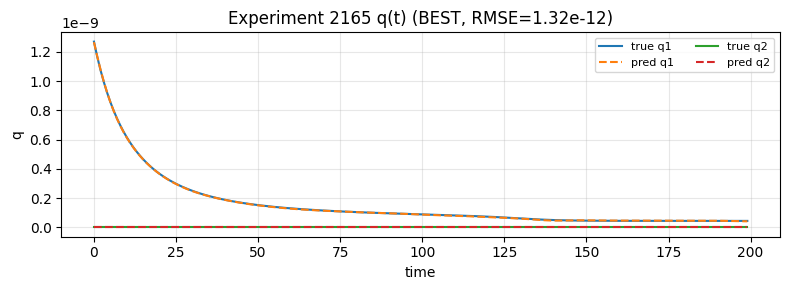

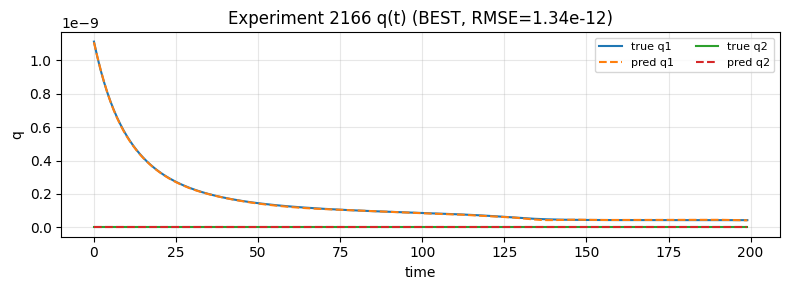

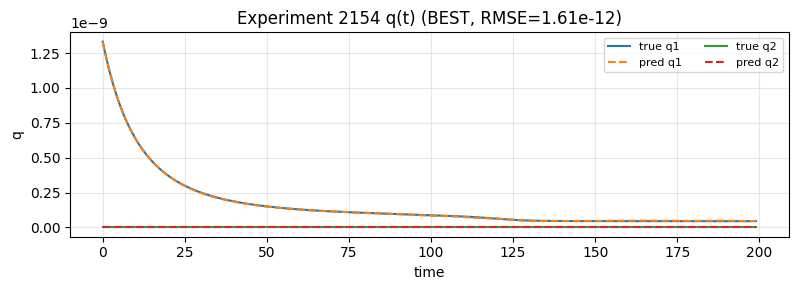

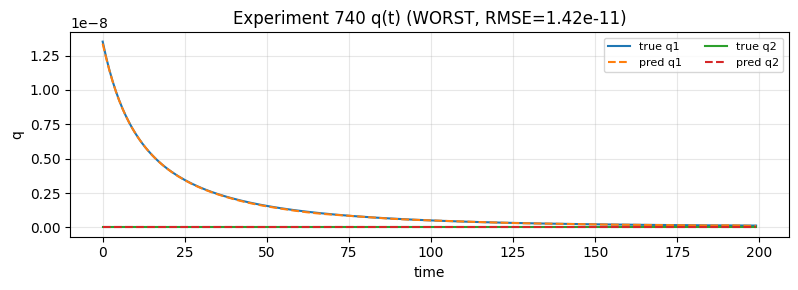

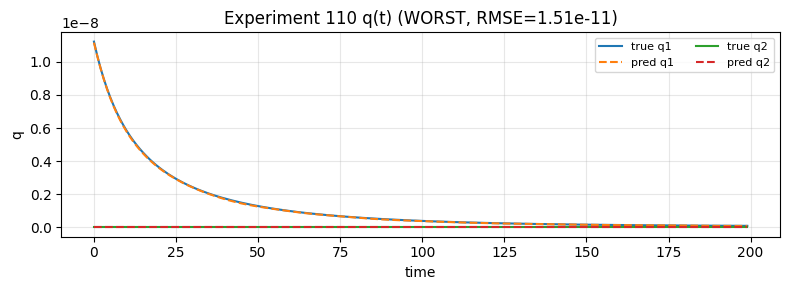

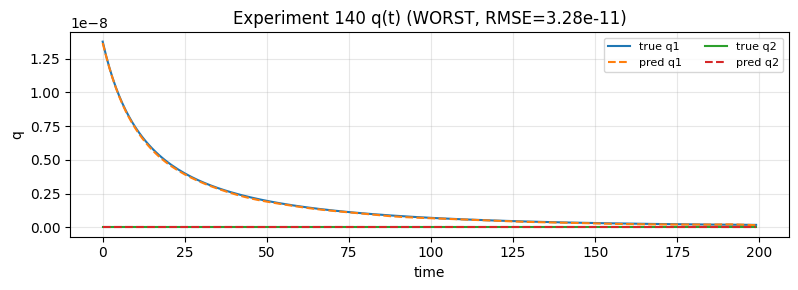

In [13]:
# 5) q-model diagnostics: training curves and scatter plots

plt.figure(figsize=(6,4))
plt.plot(hist_q.history["loss"], label="train")
plt.plot(hist_q.history["val_loss"], label="val")
plt.xlabel("epoch")
plt.ylabel("MSE loss")
plt.title("q model training")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Predictions on test set (physical q)
y_te_pred_s = model_q.predict(X_te_q_s, batch_size=4096, verbose=0)
y_te_pred   = unscale_q(y_te_pred_s)   # shape (N_test_samples, r)

# --- Build test-only meta arrays so indices line up ---
meta_te    = meta[mask_te_q]          # rows aligned with X_te_q_s / y_te_q / y_te_pred
exp_ids_all = exp_ids                 # full array
exp_ids_te  = exp_ids_all[mask_te_q]  # experiment id per TEST row (same length as y_te_q)

# 5a) Pred vs true scatter per reaction
plt.figure(figsize=(5*r, 4))
for j in range(r):
    plt.subplot(1, r, j + 1)
    plt.scatter(y_te_q[:, j], y_te_pred[:, j], s=6, alpha=0.4)
    lo = min(y_te_q[:, j].min(), y_te_pred[:, j].min())
    hi = max(y_te_q[:, j].max(), y_te_pred[:, j].max())
    plt.plot([lo, hi], [lo, hi], "k--", lw=1)
    plt.xlabel("true q")
    plt.ylabel("pred q")
    plt.title(f"Reaction {j+1}")
plt.tight_layout()
plt.show()

# 5b) Per-experiment RMSE on q
def per_experiment_rmse(exp_ids_subset, y_true, y_hat):
    rmse_by_exp = []
    for e in np.unique(exp_ids_subset):
        idx = (exp_ids_subset == e)
        if np.sum(idx) == 0:
            continue
        rmse_e = np.sqrt(np.mean((y_true[idx] - y_hat[idx])**2))
        rmse_by_exp.append((e, rmse_e))
    rmse_by_exp.sort(key=lambda x: x[1])
    return rmse_by_exp

ranking_q = per_experiment_rmse(exp_ids_te, y_te_q, y_te_pred)
Nshow = 3
best_q  = ranking_q[:Nshow]
worst_q = ranking_q[-Nshow:]
print("Best experiments (q RMSE):", best_q)
print("Worst experiments (q RMSE):", worst_q)

# 5c) Plot q(t) for best / worst experiments
def plot_q_time_series_for_exp(exp_id, title_suffix=""):
    # indices into TEST arrays (y_te_q, y_te_pred, meta_te, etc.)
    idx = np.where(exp_ids_te == exp_id)[0]
    if idx.size == 0:
        print(f"No test samples for exp {exp_id}")
        return

    # recover time indices and sort
    t_idx = meta_te[idx, 1].astype(int)     # second column of meta is k (time index)
    order = np.argsort(t_idx)
    idx_sorted = idx[order]
    tt = t_eval[:-1][t_idx[order]]

    y_true = y_te_q[idx_sorted]
    y_hat  = y_te_pred[idx_sorted]

    plt.figure(figsize=(8,3))
    for j in range(r):
        plt.plot(tt, y_true[:, j], label=f"true q{j+1}")
        plt.plot(tt, y_hat[:, j], "--", label=f"pred q{j+1}")
    plt.xlabel("time")
    plt.ylabel("q")
    plt.title(f"Experiment {exp_id} q(t) {title_suffix}")
    plt.legend(ncol=2, fontsize=8)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

for e, rmse_val in best_q:
    plot_q_time_series_for_exp(e, title_suffix=f"(BEST, RMSE={rmse_val:.2e})")

for e, rmse_val in worst_q:
    plot_q_time_series_for_exp(e, title_suffix=f"(WORST, RMSE={rmse_val:.2e})")


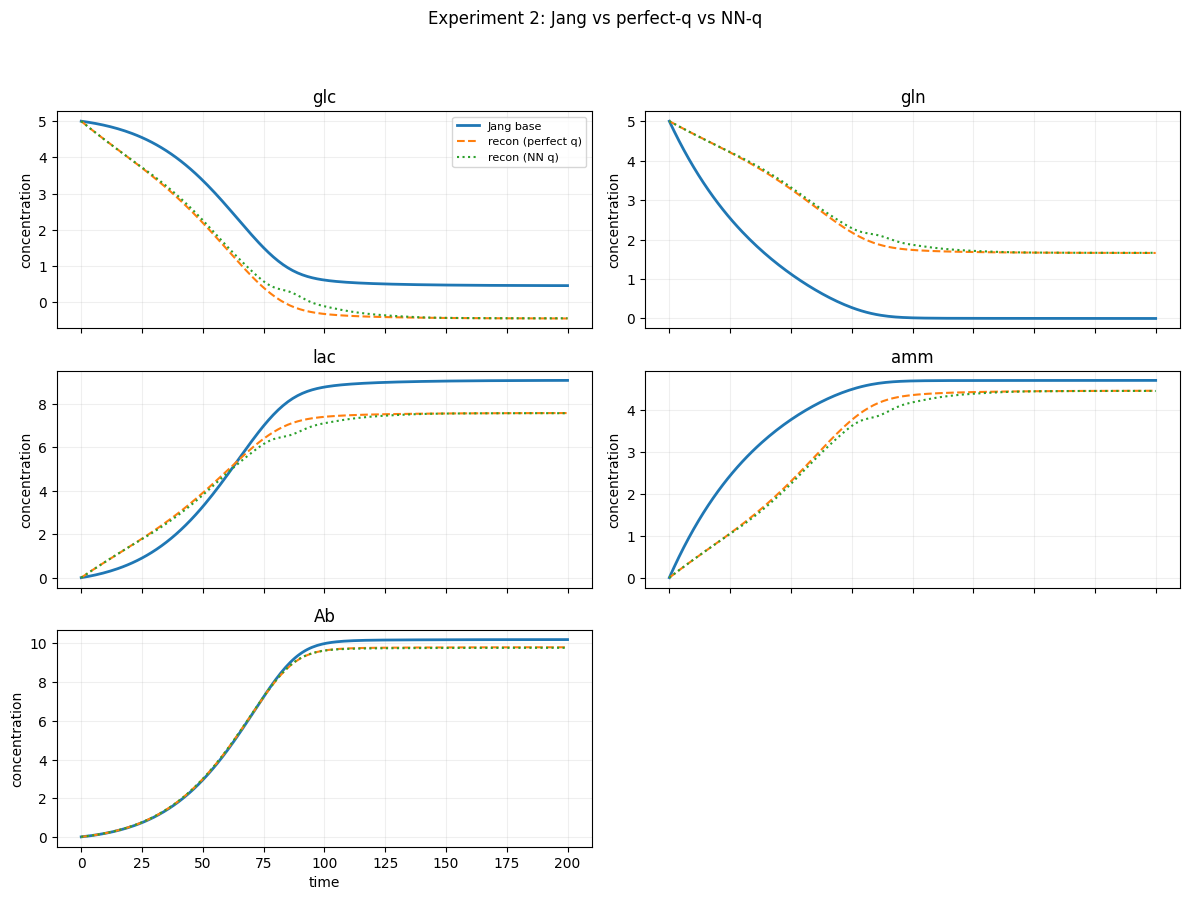

[Exp 2] RMSE (perfect q vs Jang) per species: [0.9395088  1.72294505 1.18400891 0.78596878 0.29031369]
[Exp 2] RMSE (NN q vs Jang) per species: [0.86475583 1.77184984 1.26314283 0.83898568 0.30838664]


In [14]:

# 6) Reconstruction: compare Jang base case vs "perfect" q vs NN q

def rhs_interp_q_tilde(ti, C_tilde_i, t_grid, Xv_grid, S_tilde_mat, q_grid):
    """ODE in dimensionless coordinates: dC_tilde/dt = Xv(t) * S_tilde * q(t)."""
    k = np.searchsorted(t_grid, ti, side="right") - 1
    k = np.clip(k, 0, q_grid.shape[0] - 1)
    if k == q_grid.shape[0] - 1:
        q_t = q_grid[k]
    else:
        tL, tR = t_grid[k], t_grid[k + 1]
        alpha = 0.0 if tR == tL else (ti - tL) / (tR - tL)
        q_t = (1.0 - alpha) * q_grid[k] + alpha * q_grid[k + 1]

    k2 = np.searchsorted(t_grid, ti, side="right") - 1
    k2 = np.clip(k2, 0, len(Xv_grid) - 2)
    tL2, tR2 = t_grid[k2], t_grid[k2 + 1]
    alpha2 = 0.0 if tR2 == tL2 else (ti - tL2) / (tR2 - tL2)
    Xv_t = (1.0 - alpha2) * Xv_grid[k2] + alpha2 * Xv_grid[k2 + 1]

    return (Xv_t * S_tilde_mat) @ q_t


def integrate_with_q_tilde(C0_phys, t_grid, Xv_grid, S_tilde_mat, q_grid):
    C0_tilde = C0_phys / C_scale
    sol = solve_ivp(
        fun=lambda t, Ctil: rhs_interp_q_tilde(t, Ctil, t_grid, Xv_grid, S_tilde_mat, q_grid),
        t_span=(float(t_grid[0]), float(t_grid[-1])),
        y0=C0_tilde.astype(float),
        t_eval=t_grid.astype(float),
        method="RK45",
        rtol=1e-6,
        atol=1e-9,
    )
    C_tilde = sol.y
    C_phys = C_scale[:, None] * C_tilde
    return C_phys


def compute_true_q_for_experiment(e_idx):
    C_true = all_C[e_idx]
    Xv_true = all_Xv[e_idx]
    C_tilde = C_true / C_scale[:, None]
    dC_tilde = finite_diff(C_tilde, t_eval)
    q_true = windowed_ridge_q(
        Xv_vec=Xv_true[:-1],
        S_mat=S_tilde,
        dC_tilde=dC_tilde,
        lam=lam,
        win_len=Wlen,
    )   # (r, T-1)
    return q_true.T  # (T-1, r)


def predict_q_for_experiment(e_idx):
    C = all_C[e_idx]
    Xv = all_Xv[e_idx]
    C0 = all_C0[e_idx]
    Xv0 = all_Xv0[e_idx]

    Tm1 = t_eval.shape[0] - 1
    C0_rep  = np.repeat(C0[None, :],  Tm1, axis=0)
    Xv0_rep = np.repeat([[Xv0]],       Tm1, axis=0)
    Xv_t    = Xv[:-1][:, None]

    X_e_raw = np.concatenate([C0_rep, Xv0_rep, Xv_t, F_time_q], axis=1)
    X_e_s   = norm_X(X_e_raw, x_min_q, x_rng_q)

    q_pred_s = model_q.predict(X_e_s, batch_size=1024, verbose=0)
    q_pred   = unscale_q(q_pred_s)
    return q_pred  # (T-1, r)


def compare_reconstruction(exp_idx):
    C_true  = all_C[exp_idx]    # (m, T)
    Xv_true = all_Xv[exp_idx]   # (T,)
    C0      = C_true[:, 0]

    q_true = compute_true_q_for_experiment(exp_idx)   # (T-1, r)
    q_pred = predict_q_for_experiment(exp_idx)        # (T-1, r)

    C_recon_true = integrate_with_q_tilde(C0, t_eval, Xv_true, S_tilde, q_true)
    C_recon_pred = integrate_with_q_tilde(C0, t_eval, Xv_true, S_tilde, q_pred)

    m_local = C_true.shape[0]
    ncols = 2
    nrows = int(np.ceil(m_local / ncols))

    fig, axes = plt.subplots(nrows, ncols, figsize=(12, 3 * nrows), sharex=True)
    axes = np.atleast_2d(axes)

    for i in range(m_local):
        r_i = i // ncols
        c_i = i % ncols
        ax = axes[r_i, c_i]

        sp = species_names[i] if i < len(species_names) else f"species {i}"
        ax.plot(t_eval, C_true[i],        label="Jang base", lw=2)
        ax.plot(t_eval, C_recon_true[i], "--", label="recon (perfect q)", lw=1.5)
        ax.plot(t_eval, C_recon_pred[i], ":", label="recon (NN q)", lw=1.5)
        ax.set_title(sp)
        ax.set_ylabel("concentration")
        ax.grid(alpha=0.2)
        if r_i == nrows - 1:
            ax.set_xlabel("time")

    axes[0, 0].legend(fontsize=8)
    for j in range(m_local, nrows * ncols):
        fig.delaxes(axes.flatten()[j])

    fig.suptitle(f"Experiment {exp_idx}: Jang vs perfect-q vs NN-q", y=0.995)
    fig.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    rmse = lambda A, B: np.sqrt(np.mean((A - B)**2, axis=1))
    print(f"[Exp {exp_idx}] RMSE (perfect q vs Jang) per species:", rmse(C_recon_true, C_true))
    print(f"[Exp {exp_idx}] RMSE (NN q vs Jang) per species:",      rmse(C_recon_pred, C_true))


# Example call (you can change the index later in the notebook):
compare_reconstruction(exp_idx=int(test_exps[0]))


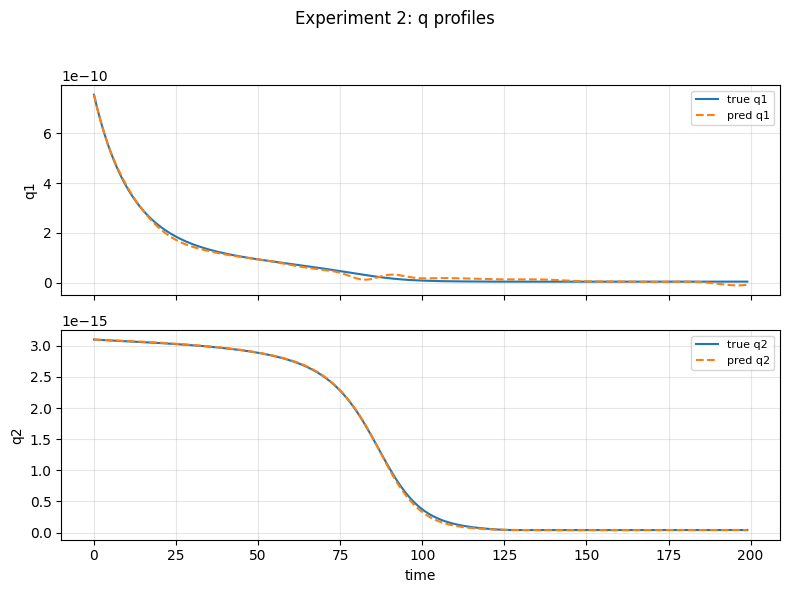

In [15]:

# 7) Optional: visualise q1 and q2 profiles for a selected experiment (for Chapter 5)

def plot_q_profiles_for_experiment(exp_idx):
    q_true = compute_true_q_for_experiment(exp_idx)
    q_pred = predict_q_for_experiment(exp_idx)

    tt = t_eval[:-1]

    fig, axes = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
    for j in range(r):
        ax = axes[j]
        ax.plot(tt, q_true[:, j], label=f"true q{j+1}")
        ax.plot(tt, q_pred[:, j], "--", label=f"pred q{j+1}")
        ax.set_ylabel(f"q{j+1}")
        ax.grid(alpha=0.3)
        ax.legend(fontsize=8)
    axes[-1].set_xlabel("time")
    fig.suptitle(f"Experiment {exp_idx}: q profiles", y=0.98)
    fig.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

plot_q_profiles_for_experiment(exp_idx=int(test_exps[0]))


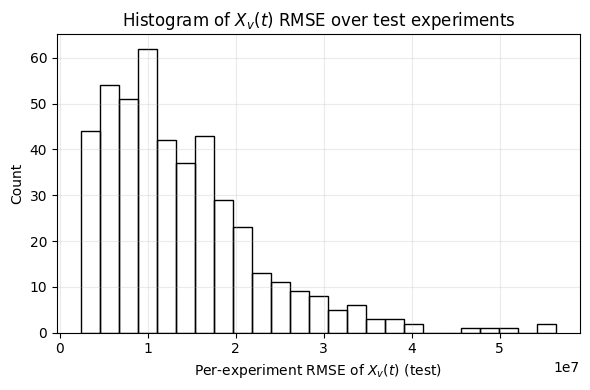

,Split,RMSE(Xv),R2(Xv)
0,Train,15634214.0,0.995342
1,Validation,15853504.0,0.995069
2,Test,16364267.0,0.994801


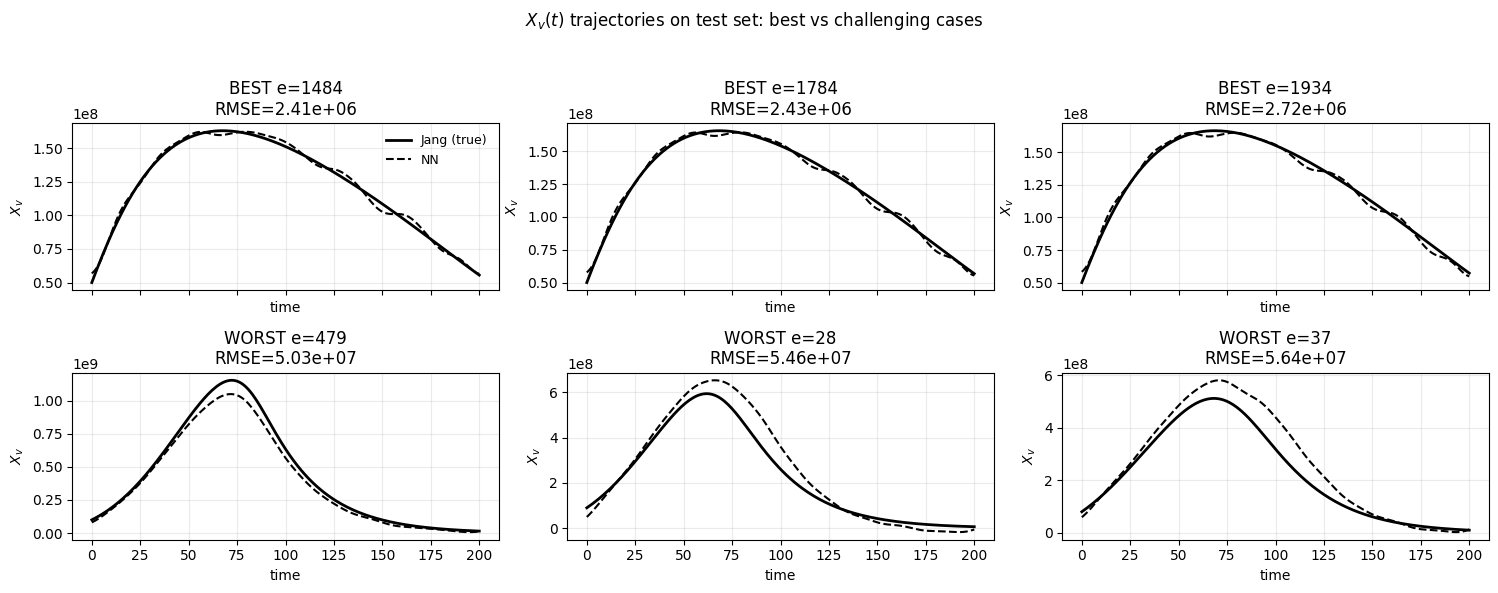

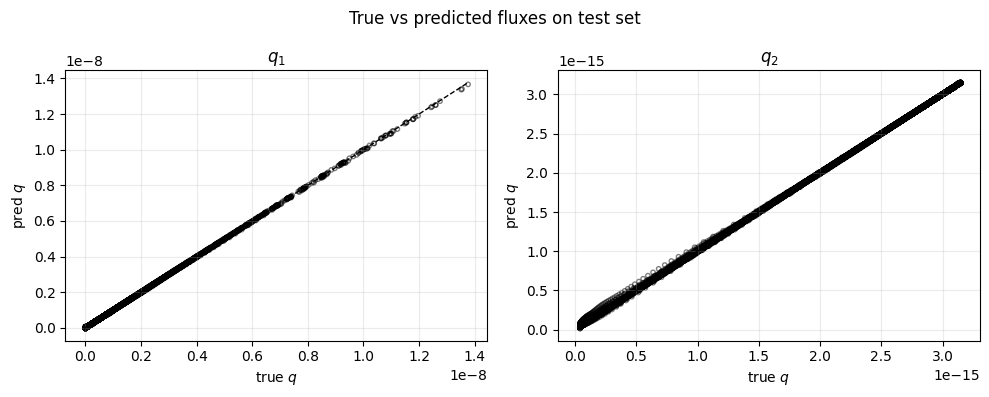

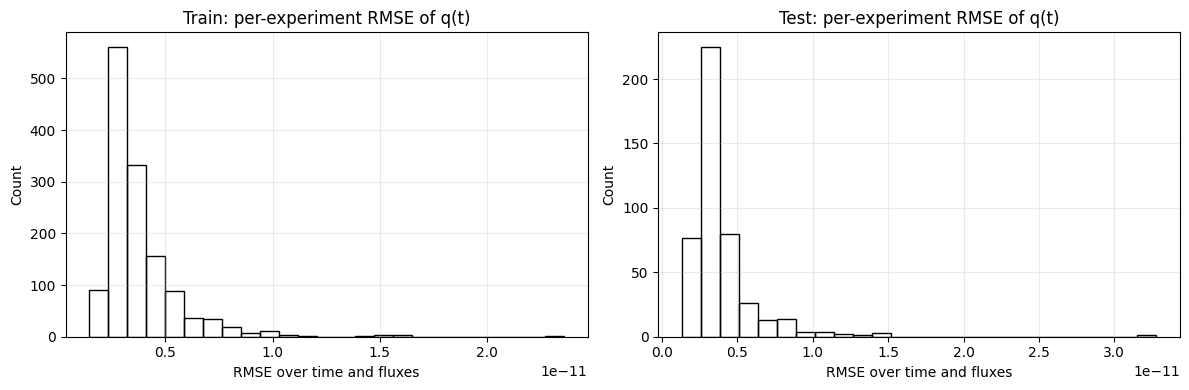

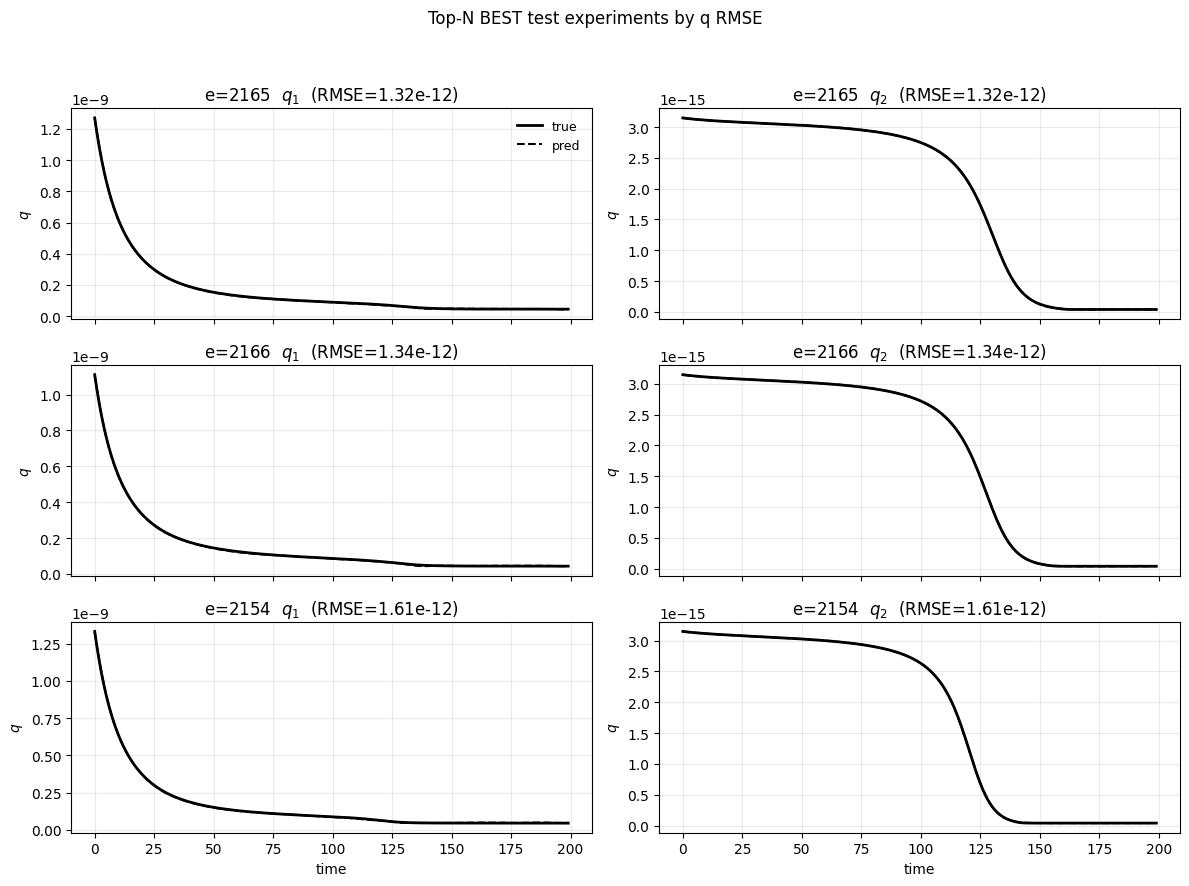

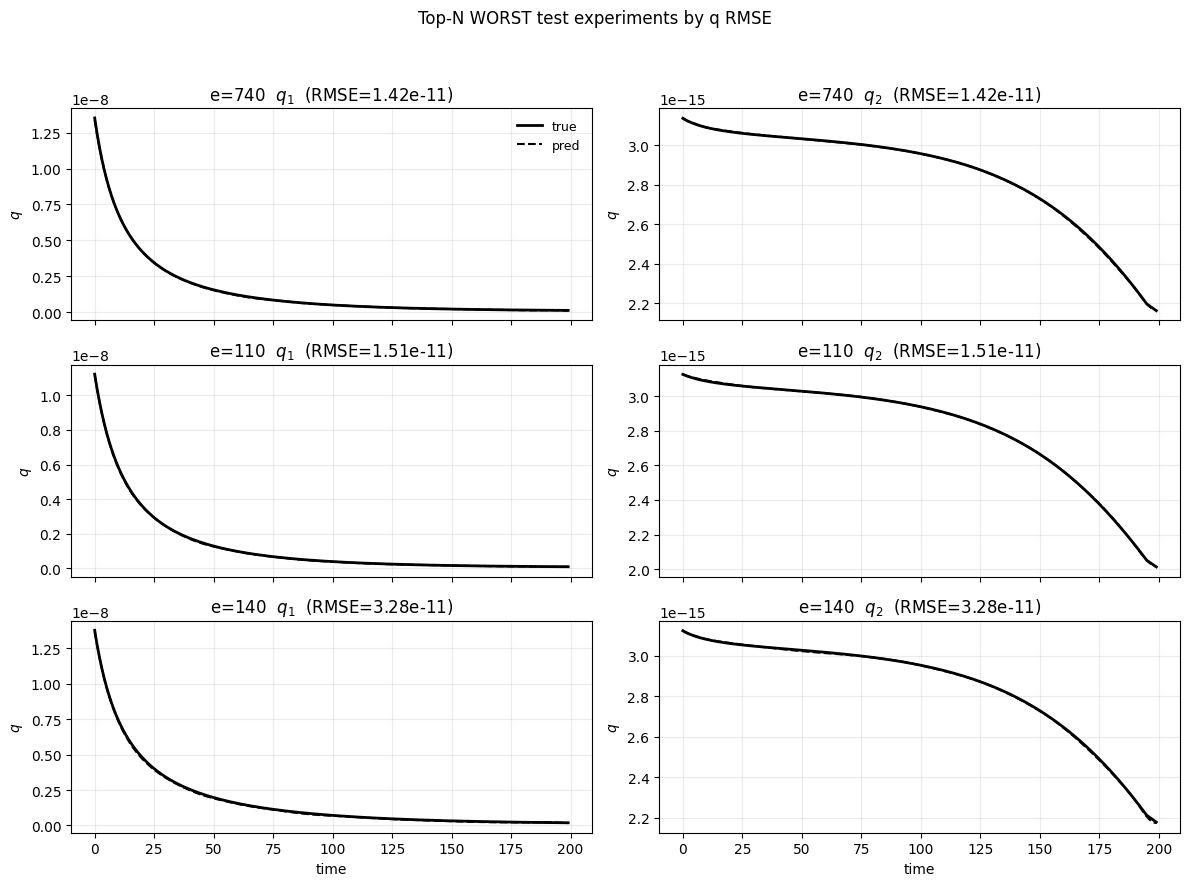

In [20]:
# =======================
# Visualisations (B/W only)
# =======================

# ---------- small helpers ----------
def _to_1d(x):
    """Force array-like to shape (T,)"""
    return np.asarray(x).reshape(-1)

def rmse(a, b):
    a = _to_1d(a); b = _to_1d(b)
    return float(np.sqrt(np.mean((a - b) ** 2)))

def denorm_xv(xv_s, y_min, y_rng):
    # xv_s can be (T,), (1,T), (T,1), (1,T,1) -> return (T,)
    return _to_1d(np.asarray(xv_s) * y_rng + y_min)

def rmse_flat(y_true, y_pred):
    return rmse(y_true, y_pred)

# Map from global row indices -> subset positions (for q subsets)
def global_to_subset_pos(global_idx, subset_mask):
    subset_rows = np.where(subset_mask)[0]              # sorted global indices
    pos = np.searchsorted(subset_rows, global_idx)      # positions into subset arrays
    return pos

# =======================
# 1) Histogram of per-experiment RMSE for Xv(t) on TEST
# =======================
xv_rmse_te = []
for j, e in enumerate(test_exps):
    # model_xv output expected shape (1,T,1) or (1,T) depending on your model
    xv_pred_s = model_xv.predict(X_te_seq[j:j+1], verbose=0)
    xv_pred   = denorm_xv(xv_pred_s, y_min_xv, y_rng_xv)         # (T,)
    xv_true   = _to_1d(Xv_te[j])                                 # (T,)
    xv_rmse_te.append(rmse(xv_true, xv_pred))

xv_rmse_te = np.asarray(xv_rmse_te)

plt.figure(figsize=(6,4))
plt.hist(xv_rmse_te, bins=25, edgecolor="k", facecolor="none")
plt.xlabel("Per-experiment RMSE of $X_v(t)$ (test)")
plt.ylabel("Count")
plt.title("Histogram of $X_v(t)$ RMSE over test experiments")
plt.grid(alpha=0.25)
plt.tight_layout()
plt.show()


# =======================
# 2) Table: Overall RMSE and R^2 for Xv on train/val/test
# =======================
def overall_xv_metrics_seq(X_seq, Xv_array):
    """
    X_seq: (Nexp, T, Din)
    Xv_array: (Nexp, T) array OR list length Nexp, each (T,)
    """
    Xv_array = np.asarray(Xv_array) if not isinstance(Xv_array, list) else Xv_array

    preds_flat, trues_flat = [], []
    N = X_seq.shape[0]

    for j in range(N):
        xv_pred_s = model_xv.predict(X_seq[j:j+1], verbose=0)
        xv_pred   = denorm_xv(xv_pred_s, y_min_xv, y_rng_xv)   # (T,)

        if isinstance(Xv_array, list):
            xv_true = _to_1d(Xv_array[j])
        else:
            xv_true = _to_1d(Xv_array[j, :])

        preds_flat.append(xv_pred)
        trues_flat.append(xv_true)

    preds_flat = np.concatenate(preds_flat, axis=0)  # (Nexp*T,)
    trues_flat = np.concatenate(trues_flat, axis=0)  # (Nexp*T,)

    return rmse_flat(trues_flat, preds_flat), float(r2_score(trues_flat, preds_flat))

rmse_tr, r2_tr = overall_xv_metrics_seq(X_tr_seq, Xv_tr)
rmse_va, r2_va = overall_xv_metrics_seq(X_va_seq, Xv_va)
rmse_te, r2_te = overall_xv_metrics_seq(X_te_seq, Xv_te)

df_xv = pd.DataFrame({
    "Split": ["Train", "Validation", "Test"],
    "RMSE(Xv)": [rmse_tr, rmse_va, rmse_te],
    "R2(Xv)":   [r2_tr,   r2_va,   r2_te],
})
display(df_xv)


# =======================
# 3) Example Xv(t) trajectories: best & challenging TEST cases (subplots)
# =======================
Nshow = 3
order = np.argsort(xv_rmse_te)
best_idx  = order[:Nshow]
worst_idx = order[-Nshow:]

fig, axes = plt.subplots(2, Nshow, figsize=(5*Nshow, 6), sharex=True)
axes = np.atleast_2d(axes)

for col, j in enumerate(best_idx):
    ax = axes[0, col]
    xv_pred_s = model_xv.predict(X_te_seq[j:j+1], verbose=0)
    xv_pred   = denorm_xv(xv_pred_s, y_min_xv, y_rng_xv)     # (T,)
    ax.plot(t_eval, _to_1d(Xv_te[j]), color="k", lw=2, label="Jang (true)")
    ax.plot(t_eval, xv_pred,          color="k", lw=1.5, ls="--", label="NN")
    ax.set_title(f"BEST e={test_exps[j]}\nRMSE={xv_rmse_te[j]:.2e}")
    ax.grid(alpha=0.25)
    ax.set_xlabel("time")
    ax.set_ylabel("$X_v$")

for col, j in enumerate(worst_idx):
    ax = axes[1, col]
    xv_pred_s = model_xv.predict(X_te_seq[j:j+1], verbose=0)
    xv_pred   = denorm_xv(xv_pred_s, y_min_xv, y_rng_xv)     # (T,)
    ax.plot(t_eval, _to_1d(Xv_te[j]), color="k", lw=2, label="Jang (true)")
    ax.plot(t_eval, xv_pred,          color="k", lw=1.5, ls="--", label="NN")
    ax.set_title(f"WORST e={test_exps[j]}\nRMSE={xv_rmse_te[j]:.2e}")
    ax.grid(alpha=0.25)
    ax.set_xlabel("time")
    ax.set_ylabel("$X_v$")

axes[0,0].legend(frameon=False, fontsize=9)
fig.suptitle("$X_v(t)$ trajectories on test set: best vs challenging cases", y=0.98)
fig.tight_layout(rect=[0,0,1,0.95])
plt.show()


# =======================
# q helpers: safe per-experiment grouping (FIXES your IndexError)
# =======================
def per_experiment_rmse_from_subset(exp_ids_subset, y_true_subset, y_hat_subset):
    out = []
    for e in np.unique(exp_ids_subset):
        idx = (exp_ids_subset == e)
        if np.sum(idx) == 0:
            continue
        out.append((int(e), float(rmse(y_true_subset[idx], y_hat_subset[idx]))))
    out.sort(key=lambda x: x[1])
    return out

def get_time_sorted_q_series_for_exp(exp_id, subset_mask, y_true_subset, y_hat_subset):
    """
    Returns tt, y_true(t,:), y_hat(t,:) for a single exp_id,
    correctly mapping GLOBAL rows -> SUBSET positions.
    """
    rows_global = np.where((exp_ids == exp_id) & subset_mask)[0]  # global indices
    if rows_global.size == 0:
        return None

    pos = global_to_subset_pos(rows_global, subset_mask)          # subset positions
    # time indices from meta for those GLOBAL rows
    t_idx = meta[rows_global, 1].astype(int)
    order = np.argsort(t_idx)

    tt    = t_eval[:-1][t_idx[order]]
    ytrue = y_true_subset[pos][order]   # <-- CORRECT (subset indexing)
    yhat  = y_hat_subset[pos][order]    # <-- CORRECT (subset indexing)
    return tt, ytrue, yhat


# =======================
# 6) Scatter: true vs predicted q1,q2 on TEST (diagonal)
# =======================
y_te_pred = unscale_q(model_q.predict(X_te_q_s, batch_size=4096, verbose=0))
r = y_te_q.shape[1]

fig, axes = plt.subplots(1, r, figsize=(5*r, 4))
axes = np.atleast_1d(axes)
for j in range(r):
    ax = axes[j]
    ax.scatter(y_te_q[:, j], y_te_pred[:, j], s=10, facecolors="none", edgecolors="k", alpha=0.5)
    lo = min(y_te_q[:, j].min(), y_te_pred[:, j].min())
    hi = max(y_te_q[:, j].max(), y_te_pred[:, j].max())
    ax.plot([lo, hi], [lo, hi], color="k", ls="--", lw=1)
    ax.set_xlabel("true $q$")
    ax.set_ylabel("pred $q$")
    ax.set_title(f"$q_{j+1}$")
    ax.grid(alpha=0.25)

fig.suptitle("True vs predicted fluxes on test set", y=0.98)
fig.tight_layout()
plt.show()


# =======================
# 7) Histograms: per-experiment RMSE for predicted q-trajectories on TRAIN and TEST
# =======================
y_tr_pred = unscale_q(model_q.predict(X_tr_q_s, batch_size=4096, verbose=0))

exp_ids_tr = exp_ids[mask_tr_q]
exp_ids_te = exp_ids[mask_te_q]

rank_tr = per_experiment_rmse_from_subset(exp_ids_tr, y_tr_q, y_tr_pred)
rank_te = per_experiment_rmse_from_subset(exp_ids_te, y_te_q, y_te_pred)

rmse_tr_exp = np.array([v for (_, v) in rank_tr])
rmse_te_exp = np.array([v for (_, v) in rank_te])

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(rmse_tr_exp, bins=25, edgecolor="k", facecolor="none")
axes[0].set_title("Train: per-experiment RMSE of q(t)")
axes[0].set_xlabel("RMSE over time and fluxes")
axes[0].set_ylabel("Count")
axes[0].grid(alpha=0.25)

axes[1].hist(rmse_te_exp, bins=25, edgecolor="k", facecolor="none")
axes[1].set_title("Test: per-experiment RMSE of q(t)")
axes[1].set_xlabel("RMSE over time and fluxes")
axes[1].set_ylabel("Count")
axes[1].grid(alpha=0.25)

fig.tight_layout()
plt.show()


# =======================
# 8) Time-series plots q1(t), q2(t): top N best & worst TEST experiments (by q RMSE)
# =======================
Nshow = 3
best_q  = rank_te[:Nshow]
worst_q = rank_te[-Nshow:]

def plot_q_grid(exp_list, title):
    n = len(exp_list)
    fig, axes = plt.subplots(n, r, figsize=(12, 3*n), sharex=True)
    axes = np.atleast_2d(axes)

    for i, (e, e_rmse) in enumerate(exp_list):
        got = get_time_sorted_q_series_for_exp(int(e), mask_te_q, y_te_q, y_te_pred)
        if got is None:
            continue
        tt, ytrue, yhat = got

        for j in range(r):
            ax = axes[i, j]
            ax.plot(tt, ytrue[:, j], color="k", lw=2, label="true" if (i==0) else None)
            ax.plot(tt, yhat[:, j],  color="k", lw=1.5, ls="--", label="pred" if (i==0) else None)
            ax.grid(alpha=0.25)
            ax.set_title(f"e={int(e)}  $q_{j+1}$  (RMSE={e_rmse:.2e})")
            if i == n-1:
                ax.set_xlabel("time")
            ax.set_ylabel("$q$")

    axes[0,0].legend(frameon=False, fontsize=9)
    fig.suptitle(title, y=0.98)
    fig.tight_layout(rect=[0,0,1,0.95])
    plt.show()

plot_q_grid(best_q,  "Top-N BEST test experiments by q RMSE")
plot_q_grid(worst_q, "Top-N WORST test experiments by q RMSE")


In [25]:
def _to_1d(x):
    return np.asarray(x).reshape(-1)

def rmse(a, b, axis=None):
    a = np.asarray(a); b = np.asarray(b)
    return np.sqrt(np.mean((a - b)**2, axis=axis))

def global_to_subset_pos(rows_global, subset_mask):
    """
    rows_global: indices into the GLOBAL arrays (meta/exp_ids indexing)
    subset_mask: boolean mask over GLOBAL rows indicating the subset (train/test)
    returns positions into the SUBSET arrays (y_subset etc).
    """
    # prefix sum over mask: gives subset index for each global index
    prefix = np.cumsum(subset_mask) - 1
    return prefix[rows_global]

def get_time_sorted_q_series_for_exp(exp_id, subset_mask, y_true_subset, y_hat_subset, exp_ids, meta, t_eval):
    """
    Safe per-experiment extraction for q (fixes IndexError when rows are global but arrays are subset).
    """
    rows_global = np.where((exp_ids == exp_id) & subset_mask)[0]
    if rows_global.size == 0:
        return None

    pos  = global_to_subset_pos(rows_global, subset_mask)
    t_idx = meta[rows_global, 1].astype(int)
    order = np.argsort(t_idx)

    tt    = t_eval[:-1][t_idx[order]]
    ytrue = y_true_subset[pos][order]
    yhat  = y_hat_subset[pos][order]
    return tt, ytrue, yhat


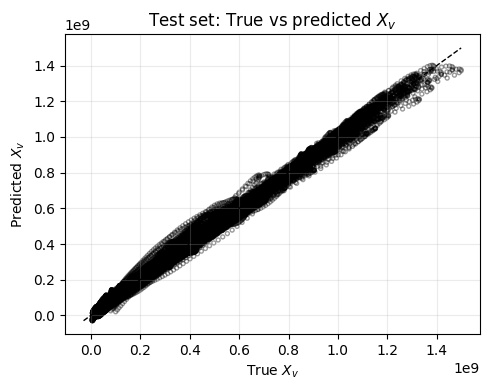

In [26]:
# Predict Xv on test in ONE batch to avoid shape surprises
Yhat_te_s = model_xv.predict(X_te_seq, verbose=0)          # (Nexp_test, T, 1) or similar
Yhat_te_s = np.asarray(Yhat_te_s).squeeze()                # -> (Nexp_test, T)

# denormalise (assumes your denorm_xv handles vector/scalar scaling)
Xv_hat_te = denorm_xv(Yhat_te_s, y_min_xv, y_rng_xv)       # -> (Nexp_test, T) expected
Xv_hat_te = np.asarray(Xv_hat_te)

X_true = _to_1d(Xv_te)          # (Nexp_test*T,)
X_pred = _to_1d(Xv_hat_te)      # (Nexp_test*T,)

lo = min(X_true.min(), X_pred.min())
hi = max(X_true.max(), X_pred.max())

plt.figure(figsize=(5,4))
plt.scatter(X_true, X_pred, s=8, facecolors="none", edgecolors="k", alpha=0.4)
plt.plot([lo, hi], [lo, hi], color="k", ls="--", lw=1)
plt.xlabel("True $X_v$")
plt.ylabel("Predicted $X_v$")
plt.title("Test set: True vs predicted $X_v$")
plt.grid(alpha=0.25)
plt.tight_layout()
plt.show()


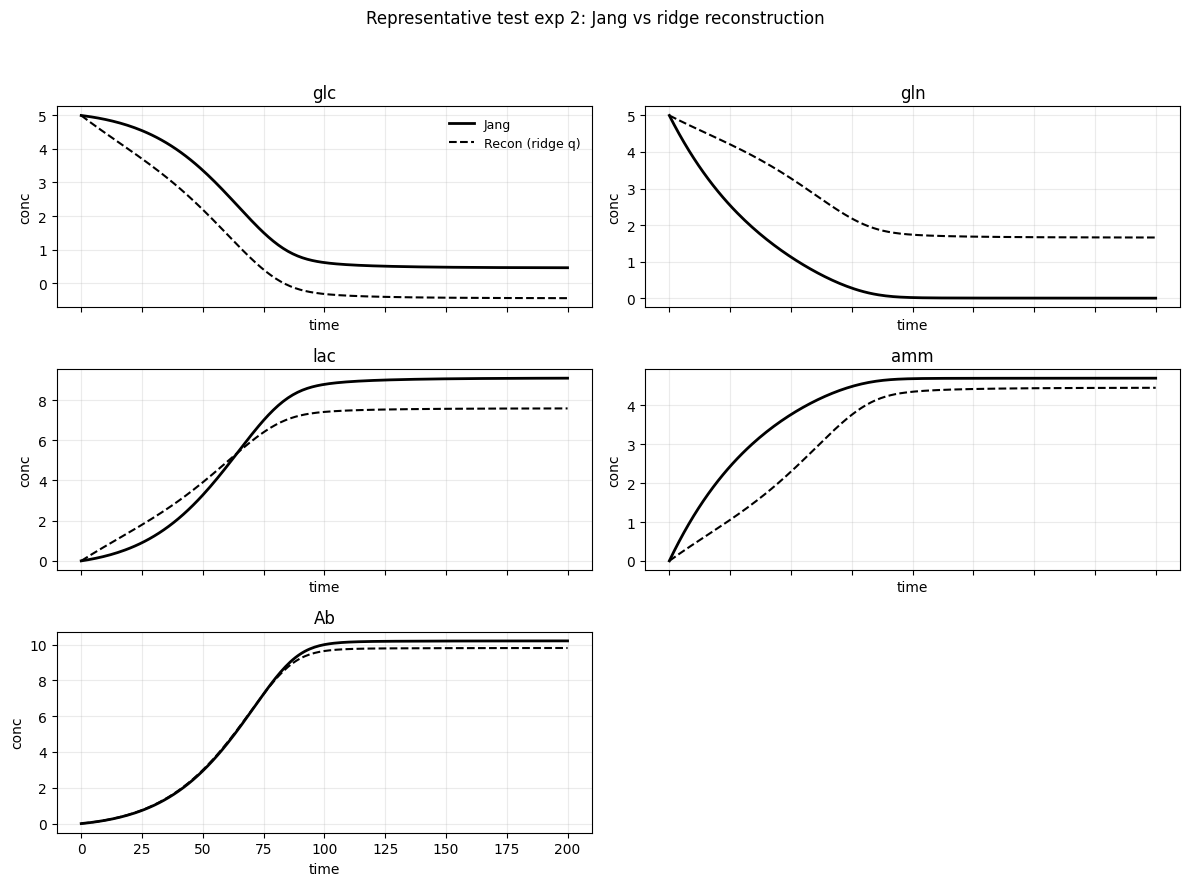

In [27]:
exp_rep = int(test_exps[0])   # change if you want

C_true  = all_C[exp_rep]      # (m, T)
Xv_true = all_Xv[exp_rep]     # (T,)
C0      = C_true[:, 0]        # (m,)

# Ridge q from this experiment (NORMAL window ridge; no weighting)
C_tilde  = C_true / C_scale[:, None]
dC_tilde = finite_diff(C_tilde, t_eval)                    # (m, T-1)
q_ridge  = windowed_ridge_q(Xv_true[:-1], S_tilde, dC_tilde).T   # (T-1, r)

C_ridge  = integrate_with_q_tilde(C0, t_eval, Xv_true, S_tilde, q_ridge)  # (m, T)

m = C_true.shape[0]
ncols = 2
nrows = int(np.ceil(m / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(12, 3*nrows), sharex=True)
axes = np.atleast_2d(axes)

for i in range(m):
    ax = axes[i // ncols, i % ncols]
    ax.plot(t_eval, C_true[i],  color="k", lw=2, label="Jang" if i==0 else None)
    ax.plot(t_eval, C_ridge[i], color="k", lw=1.5, ls="--", label="Recon (ridge q)" if i==0 else None)
    ax.set_title(species_names[i])
    ax.set_xlabel("time")
    ax.set_ylabel("conc")
    ax.grid(alpha=0.25)

axes[0,0].legend(frameon=False, fontsize=9)
for j in range(m, nrows*ncols):
    fig.delaxes(axes.flatten()[j])

fig.suptitle(f"Representative test exp {exp_rep}: Jang vs ridge reconstruction", y=0.98)
fig.tight_layout(rect=[0,0,1,0.95])
plt.show()


In [28]:
rmse_ridge_species = []

for e in test_exps:
    e = int(e)
    C_true  = all_C[e]
    Xv_true = all_Xv[e]
    C0      = C_true[:, 0]

    C_tilde  = C_true / C_scale[:, None]
    dC_tilde = finite_diff(C_tilde, t_eval)
    q_ridge  = windowed_ridge_q(Xv_true[:-1], S_tilde, dC_tilde).T  # (T-1,r)

    C_ridge  = integrate_with_q_tilde(C0, t_eval, Xv_true, S_tilde, q_ridge)

    rmse_ridge_species.append(rmse(C_ridge, C_true, axis=1))  # (m,)

rmse_ridge_species = np.vstack(rmse_ridge_species)  # (Etest, m)

df_ridge = pd.DataFrame({
    "Species": species_names,
    "RMSE mean (ridge recon)": rmse_ridge_species.mean(axis=0),
    "RMSE std  (ridge recon)": rmse_ridge_species.std(axis=0),
})
display(df_ridge)


,Species,RMSE mean (ridge recon),RMSE std (ridge recon)
0,glc,5.739667,3.506519
1,gln,10.440486,6.505404
2,lac,7.180535,3.799957
3,amm,8.700837,5.372064
4,Ab,0.230680,0.275774


F_time shape: (200, 13)


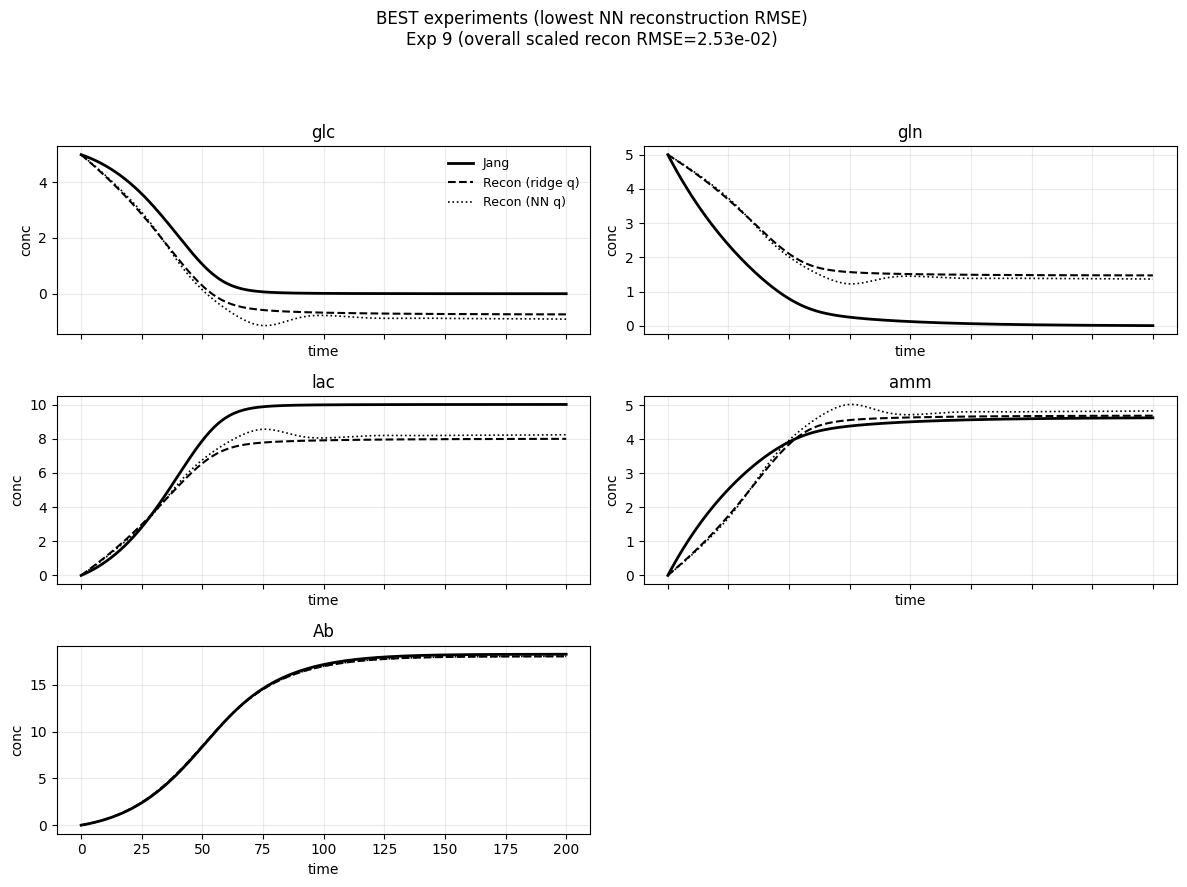

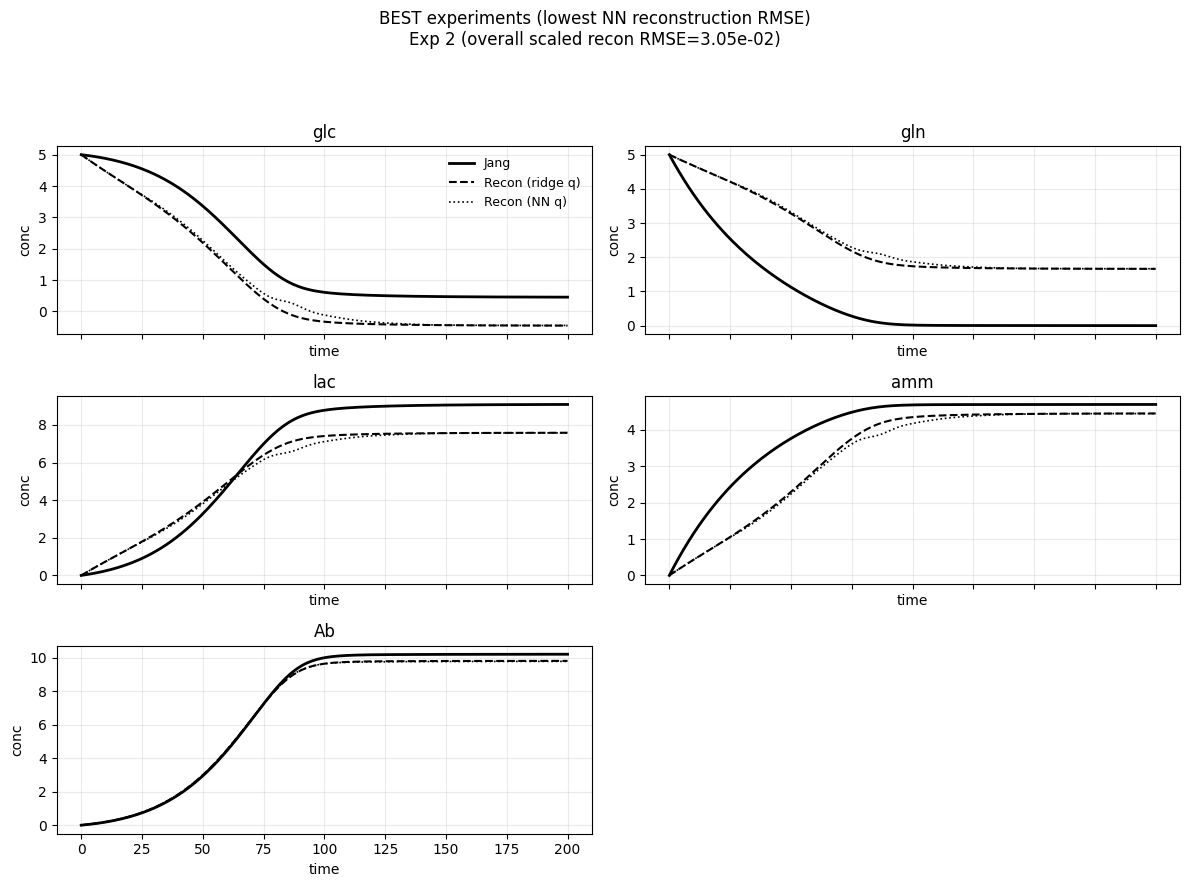

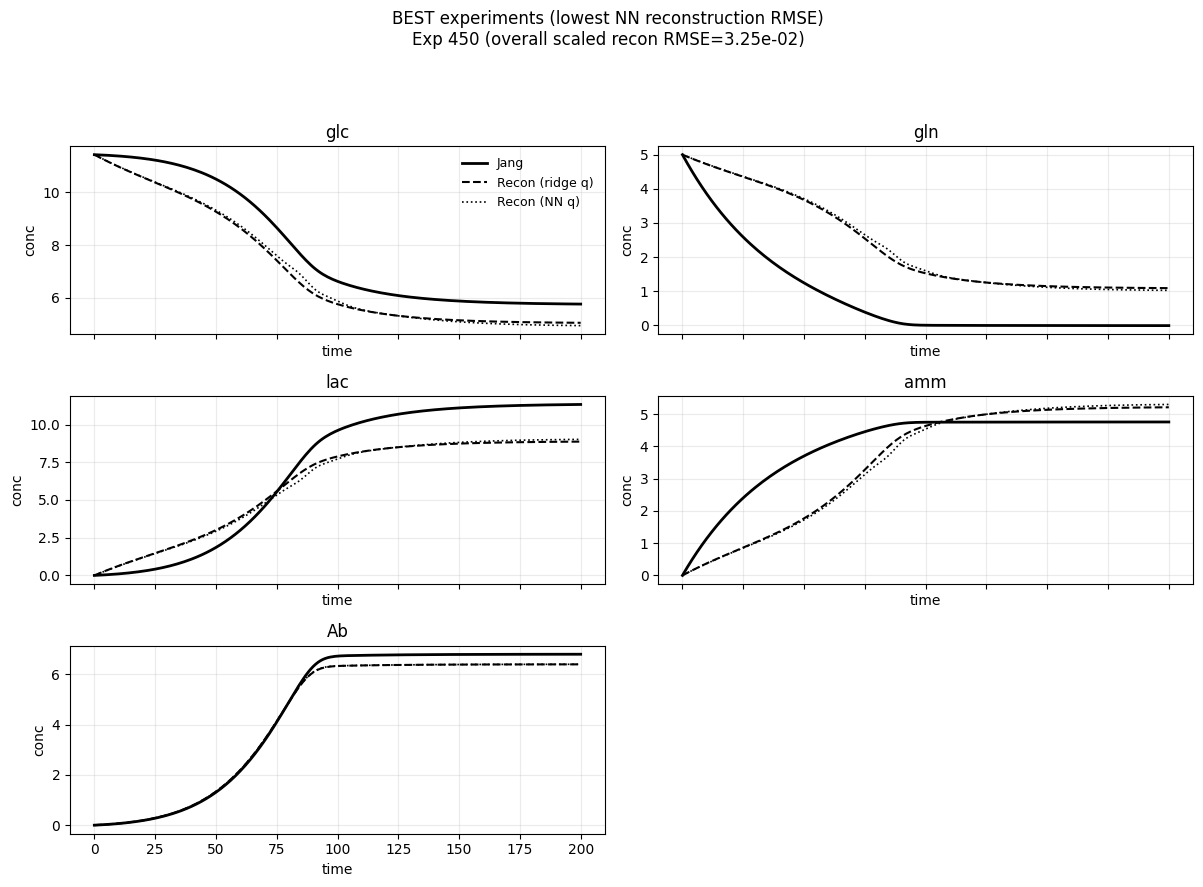

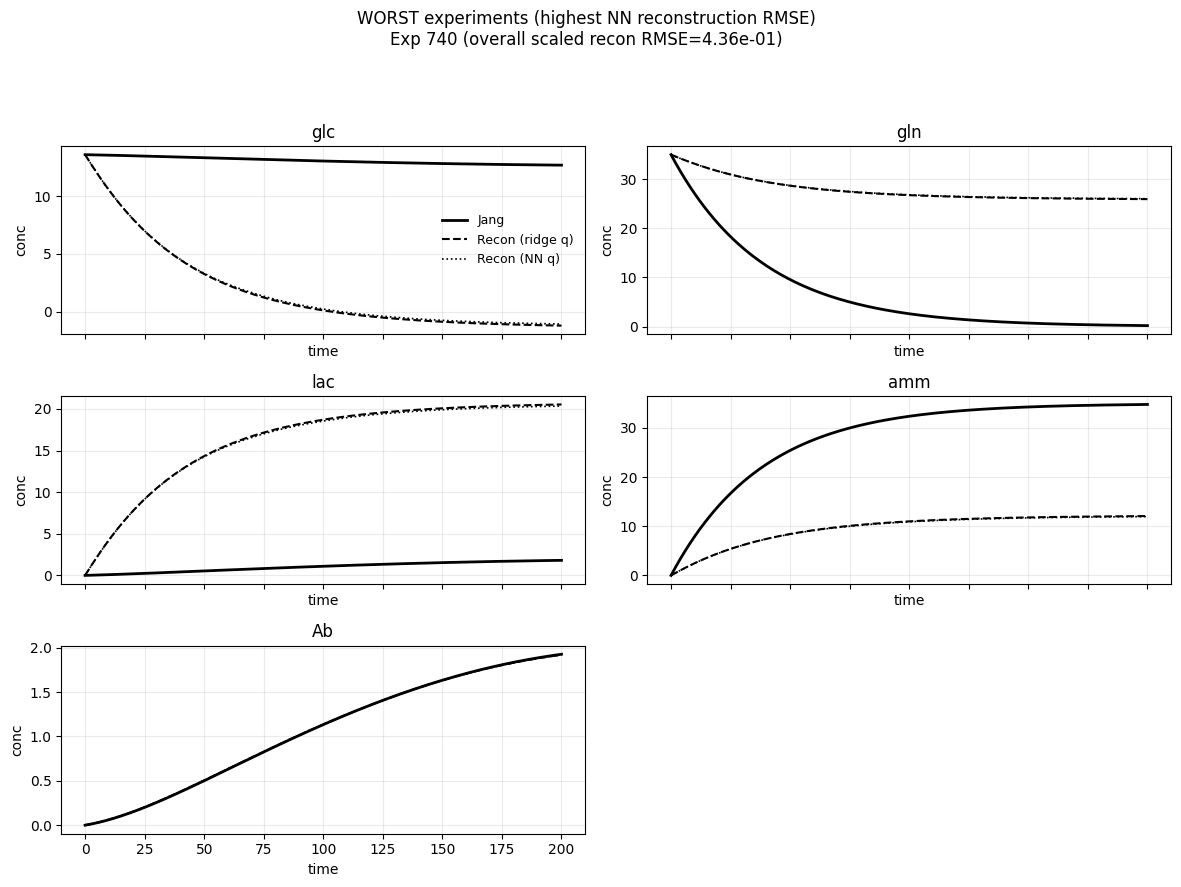

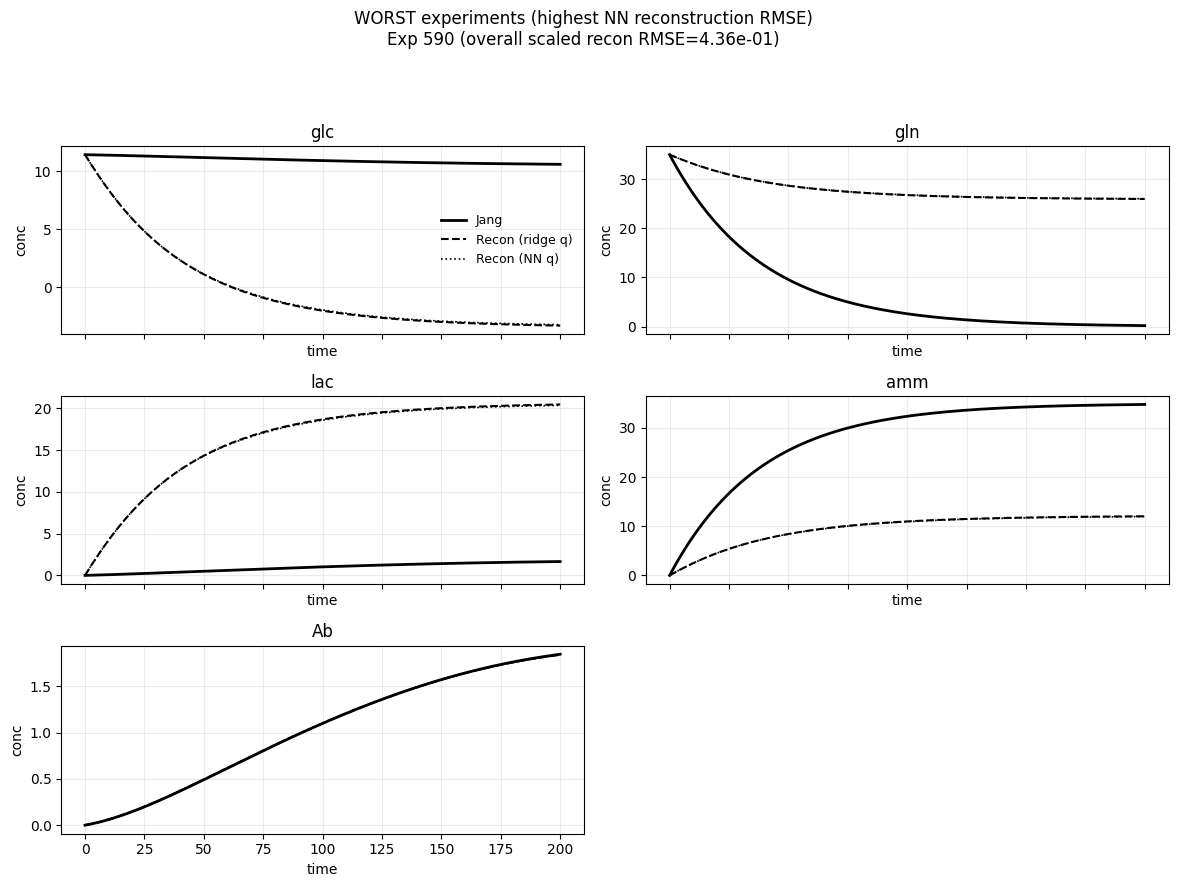

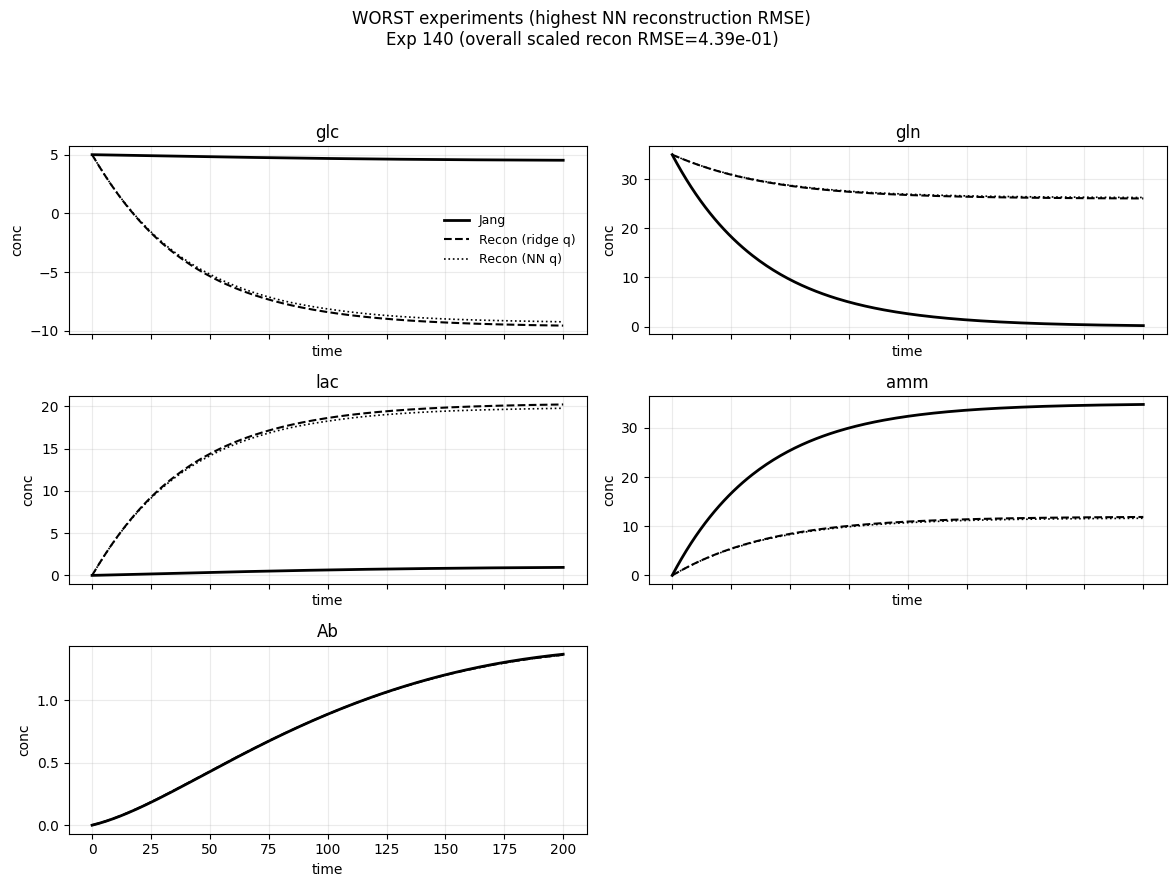

In [30]:
# ---- Time features for q model (must align with T-1 grid) ----
Tm1 = len(t_eval) - 1

# Use your existing function name (pick the one you actually have)
# If you already have fourier_time_features defined:
F_time = fourier_time_features(
    t_eval[:-1],                      # (T-1,)
    T_sim=CFG["T_sim"],
    n_freq=CFG["n_freq"],
    add_poly=CFG["use_poly"],
).astype(np.float32)

print("F_time shape:", F_time.shape)  # should be (T-1, Fd)


def predict_q_for_experiment(C0, Xv_exp):
    """
    Uses your trained q model and its scaling.
    Assumes you already have: F_time, x_min_q, x_rng_q, model_q, unscale_q
    If your variable names differ, change them here.
    """
    Tm1 = len(t_eval) - 1
    C0_rep  = np.repeat(C0[None, :], Tm1, axis=0)
    Xv0_rep = np.repeat([[Xv_exp[0]]], Tm1, axis=0)
    Xv_t    = Xv_exp[:-1][:, None]
    X_raw   = np.concatenate([C0_rep, Xv0_rep, Xv_t, F_time], axis=1)

    X_s = (X_raw - x_min_q) / x_rng_q
    y_s = model_q.predict(X_s, batch_size=4096, verbose=0)
    q_phys = unscale_q(y_s)     # (T-1, r)
    return q_phys

def recon_triplet_for_exp(e):
    C_true  = all_C[e]
    Xv_true = all_Xv[e]
    C0      = C_true[:, 0]

    # ridge q
    C_tilde  = C_true / C_scale[:, None]
    dC_tilde = finite_diff(C_tilde, t_eval)
    q_ridge  = windowed_ridge_q(Xv_true[:-1], S_tilde, dC_tilde).T

    # NN q
    q_nn = predict_q_for_experiment(C0=C0, Xv_exp=Xv_true)

    C_ridge = integrate_with_q_tilde(C0, t_eval, Xv_true, S_tilde, q_ridge)
    C_nn    = integrate_with_q_tilde(C0, t_eval, Xv_true, S_tilde, q_nn)

    return C_true, C_ridge, C_nn

def recon_rmse_overall_tilde(C_hat, C_true):
    Ct = C_true / C_scale[:, None]
    Ch = C_hat  / C_scale[:, None]
    return float(rmse(Ch.ravel(), Ct.ravel()))

# rank test experiments by NN reconstruction RMSE (scaled)
scores = []
for e in test_exps:
    e = int(e)
    C_true, C_ridge, C_nn = recon_triplet_for_exp(e)
    scores.append((e, recon_rmse_overall_tilde(C_nn, C_true)))

scores.sort(key=lambda x: x[1])

Nshow = 3
best_exps  = scores[:Nshow]
worst_exps = scores[-Nshow:]

def plot_recon_triplet_grid(exp_list, title):
    for (e, s) in exp_list:
        C_true, C_ridge, C_nn = recon_triplet_for_exp(int(e))

        m = C_true.shape[0]
        ncols = 2
        nrows = int(np.ceil(m / ncols))
        fig, axes = plt.subplots(nrows, ncols, figsize=(12, 3*nrows), sharex=True)
        axes = np.atleast_2d(axes)

        for i in range(m):
            ax = axes[i // ncols, i % ncols]
            ax.plot(t_eval, C_true[i],  color="k", lw=2,   label="Jang" if i==0 else None)
            ax.plot(t_eval, C_ridge[i], color="k", lw=1.5, ls="--", label="Recon (ridge q)" if i==0 else None)
            ax.plot(t_eval, C_nn[i],    color="k", lw=1.2, ls=":",  label="Recon (NN q)" if i==0 else None)
            ax.set_title(species_names[i])
            ax.set_xlabel("time")
            ax.set_ylabel("conc")
            ax.grid(alpha=0.25)

        axes[0,0].legend(frameon=False, fontsize=9)
        for j in range(m, nrows*ncols):
            fig.delaxes(axes.flatten()[j])

        fig.suptitle(f"{title}\nExp {int(e)} (overall scaled recon RMSE={s:.2e})", y=0.98)
        fig.tight_layout(rect=[0,0,1,0.93])
        plt.show()

plot_recon_triplet_grid(best_exps,  "BEST experiments (lowest NN reconstruction RMSE)")
plot_recon_triplet_grid(worst_exps, "WORST experiments (highest NN reconstruction RMSE)")


In [31]:
rmse_ridge_list = []
rmse_nn_list    = []

for e in test_exps:
    e = int(e)
    C_true, C_ridge, C_nn = recon_triplet_for_exp(e)

    rmse_ridge_list.append(rmse(C_ridge, C_true, axis=1))  # (m,)
    rmse_nn_list.append(rmse(C_nn,    C_true, axis=1))     # (m,)

rmse_ridge_arr = np.vstack(rmse_ridge_list)  # (Etest,m)
rmse_nn_arr    = np.vstack(rmse_nn_list)     # (Etest,m)

df_recon = pd.DataFrame({
    "Species": species_names,
    "RMSE mean (ridge recon)": rmse_ridge_arr.mean(axis=0),
    "RMSE std  (ridge recon)": rmse_ridge_arr.std(axis=0),
    "RMSE mean (NN recon)":    rmse_nn_arr.mean(axis=0),
    "RMSE std  (NN recon)":    rmse_nn_arr.std(axis=0),
})
display(df_recon)


,Species,RMSE mean (ridge recon),RMSE std (ridge recon),RMSE mean (NN recon),RMSE std (NN recon)
0,glc,5.739667,3.506519,5.582094,3.504553
1,gln,10.440486,6.505404,10.531332,6.511262
2,lac,7.180535,3.799957,7.210283,3.709212
3,amm,8.700837,5.372064,8.747655,5.441857
4,Ab,0.230680,0.275774,0.227448,0.272570


,exp_id,Xv0,glc0,gln0,rmse_Xv,rmse_q1,rmse_q2
0,2,30000000.0,5.0,5.000000,24577298.0,8.270202e-12,1.320126e-17
1,7,80000000.0,5.0,5.000000,38873824.0,1.202690e-11,1.155668e-17
2,9,100000000.0,5.0,5.000000,39180140.0,1.747511e-11,2.175514e-17
3,12,30000000.0,5.0,7.142857,17772636.0,7.605222e-12,9.000999e-18
4,20,10000000.0,5.0,9.285714,26666104.0,1.289419e-11,3.556150e-18


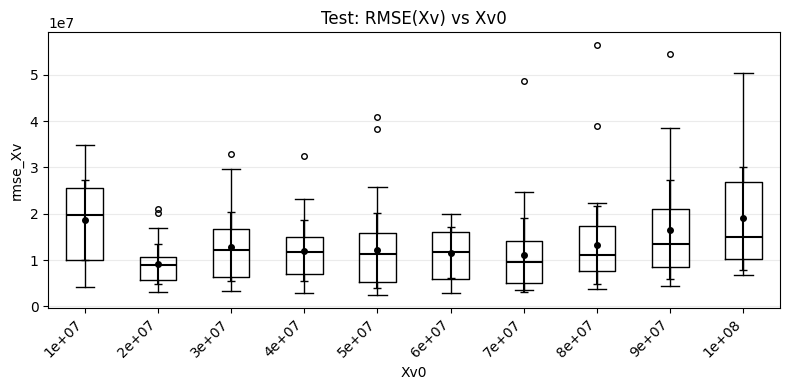

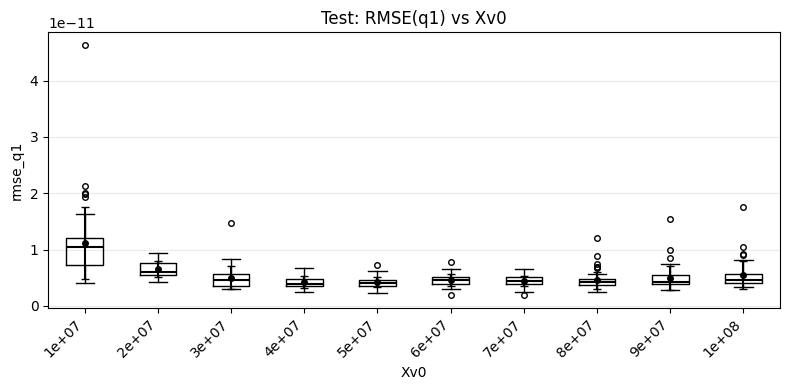

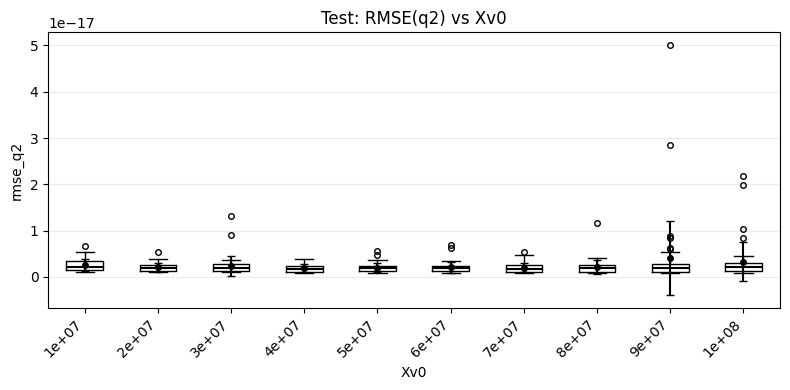

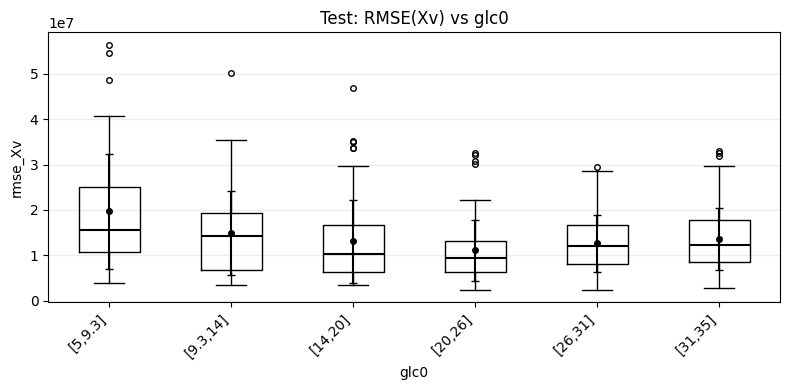

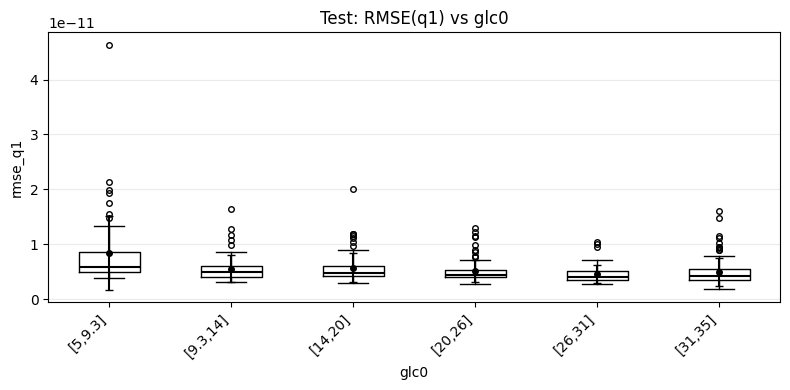

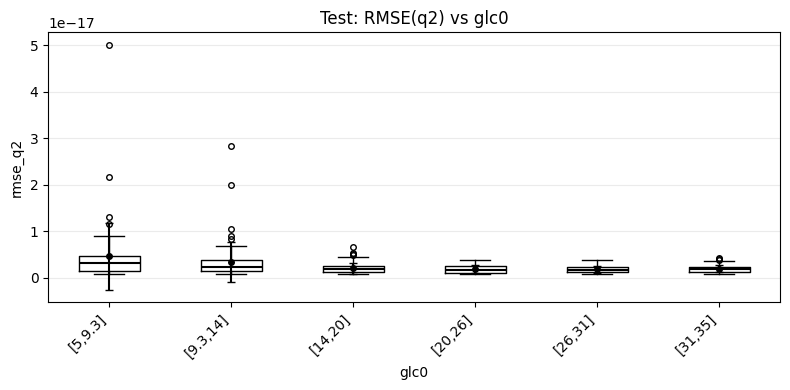

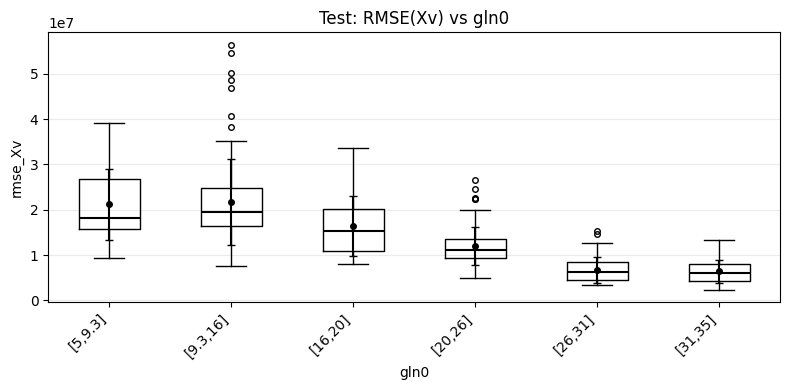

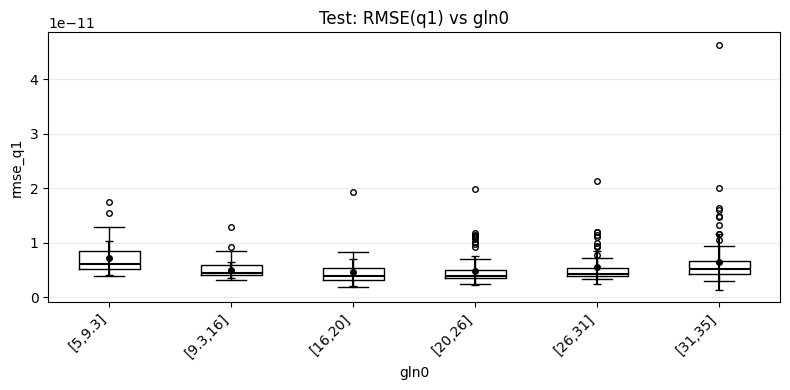

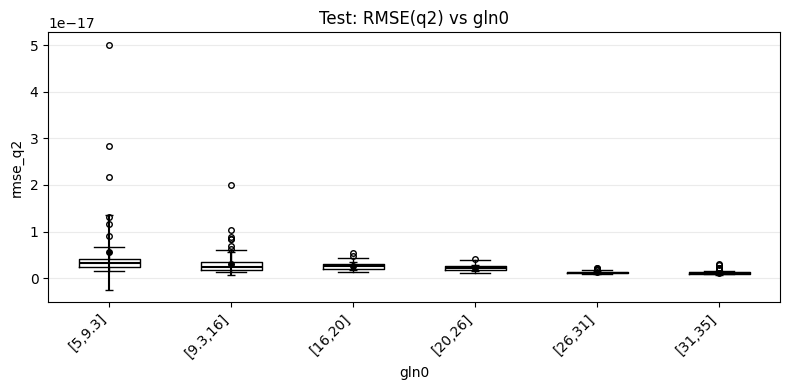

In [34]:
def per_exp_xv_rmse_on_subset(model_xv, X_seq, Xv_true, denorm_fn, y_min_xv, y_rng_xv):
    """
    Robust to model output shapes:
      (N,T,1), (N,T), (N*T,1), (N*T,)
    Robust to denorm_fn output shapes:
      (N,T), (N,T,1), (N*T,)
    """
    N, T = X_seq.shape[0], X_seq.shape[1]

    # --- prediction ---
    Yhat_s = np.asarray(model_xv.predict(X_seq, verbose=0))

    # Normalize prediction shape -> (N, T)
    if Yhat_s.ndim == 3 and Yhat_s.shape[0] == N and Yhat_s.shape[1] == T and Yhat_s.shape[2] == 1:
        Yhat_s = Yhat_s[..., 0]  # (N,T)

    elif Yhat_s.ndim == 2:
        if Yhat_s.shape == (N, T):
            pass
        elif Yhat_s.shape == (N*T, 1):
            Yhat_s = Yhat_s.reshape(N, T)
        else:
            raise ValueError(f"Unexpected model output shape: {Yhat_s.shape} (expected (N,T) or (N*T,1))")

    elif Yhat_s.ndim == 1:
        if Yhat_s.size == N*T:
            Yhat_s = Yhat_s.reshape(N, T)
        else:
            raise ValueError(f"Unexpected model output shape: {Yhat_s.shape}")

    else:
        raise ValueError(f"Unexpected model output shape: {Yhat_s.shape}")

    # --- denorm ---
    Yhat = denorm_fn(Yhat_s, y_min_xv, y_rng_xv)
    Yhat = np.asarray(Yhat)

    # Normalize denorm shape -> (N, T)
    if Yhat.ndim == 3 and Yhat.shape[0] == N and Yhat.shape[1] == T and Yhat.shape[2] == 1:
        Yhat = Yhat[..., 0]
    elif Yhat.ndim == 2 and Yhat.shape == (N, T):
        pass
    elif Yhat.ndim == 1 and Yhat.size == N*T:
        Yhat = Yhat.reshape(N, T)
    else:
        raise ValueError(f"Unexpected denorm output shape: {Yhat.shape} (expected (N,T) or flat N*T)")

    # --- true ---
    if isinstance(Xv_true, (list, tuple)):
        Xv_true = np.stack(Xv_true, axis=0)
    Xv_true = np.asarray(Xv_true)

    if Xv_true.ndim == 1 and Xv_true.size == N*T:
        Xv_true = Xv_true.reshape(N, T)

    if Xv_true.shape != (N, T):
        raise ValueError(f"Unexpected Xv_true shape: {Xv_true.shape} (expected {(N,T)})")

    rmse_e = np.sqrt(np.mean((Yhat - Xv_true) ** 2, axis=1))  # (N,)
    return rmse_e



# --- Xv RMSE per test experiment (aligned with test_exps order) ---
xv_rmse_te = per_exp_xv_rmse_on_subset(
    model_xv, X_te_seq, Xv_te,
    denorm_fn=denorm_xv,
    y_min_xv=y_min_xv, y_rng_xv=y_rng_xv
)

# --- q RMSE per test experiment (from per-timepoint subset arrays) ---
# Predict q on test set (physical)
y_te_pred = unscale_q(model_q.predict(X_te_q_s, batch_size=4096, verbose=0))  # (Nte_samples, r)
r = y_te_q.shape[1]

exp_ids_all = exp_ids
exp_ids_te  = exp_ids_all[mask_te_q]

q_rmse_by_exp = {}
for e in np.unique(exp_ids_te):
    got = get_time_sorted_q_series_for_exp(int(e), mask_te_q, y_te_q, y_te_pred, exp_ids_all, meta, t_eval)
    if got is None:
        continue
    tt, ytrue, yhat = got
    q_rmse_by_exp[int(e)] = {
        "rmse_q1": float(rmse(ytrue[:,0], yhat[:,0])),
        "rmse_q2": float(rmse(ytrue[:,1], yhat[:,1])),
    }

# --- Build per-experiment table on TEST (use test_exps list for Xv, and intersect for q) ---
rows = []
for j, e in enumerate(test_exps):
    e = int(e)
    C0 = all_C[e][:, 0]
    glc0 = float(C0[species_names.index("glc")])
    gln0 = float(C0[species_names.index("gln")])
    xv0  = float(all_Xv[e][0])

    d = {
        "exp_id": e,
        "Xv0": xv0,
        "glc0": glc0,
        "gln0": gln0,
        "rmse_Xv": float(xv_rmse_te[j]),
    }
    if e in q_rmse_by_exp:
        d.update(q_rmse_by_exp[e])
    else:
        d.update({"rmse_q1": np.nan, "rmse_q2": np.nan})

    rows.append(d)

df_rmse = pd.DataFrame(rows).dropna(subset=["rmse_q1","rmse_q2"]).copy()
display(df_rmse.head())

def boxplot_rmse_vs_feature(df, rmse_col, feature_col, nbins=6, title=""):
    x = df[feature_col].values
    y = df[rmse_col].values

    # If the feature is on a discrete grid, keep unique levels (up to 12), else quantile-bin
    uniq = np.unique(x)
    if uniq.size <= 12:
        levels = np.sort(uniq)
        groups = [y[x == lv] for lv in levels]
        labels = [f"{lv:g}" for lv in levels]
    else:
        qs = np.linspace(0, 1, nbins+1)
        edges = np.quantile(x, qs)
        edges = np.unique(edges)
        if edges.size < 3:
            # fallback: 3 bins
            edges = np.linspace(x.min(), x.max(), 4)
        groups, labels = [], []
        for a, b in zip(edges[:-1], edges[1:]):
            mask = (x >= a) & (x <= b if b == edges[-1] else x < b)
            groups.append(y[mask])
            labels.append(f"[{a:.2g},{b:.2g}]")

    # Boxplot (B/W)
    plt.figure(figsize=(max(8, 0.55*len(groups)), 4))
    bp = plt.boxplot(
        groups,
        showfliers=True,
        patch_artist=False,
        boxprops=dict(color="k"),
        medianprops=dict(color="k", linewidth=1.5),
        whiskerprops=dict(color="k"),
        capprops=dict(color="k"),
        flierprops=dict(marker="o", markerfacecolor="none", markeredgecolor="k", markersize=4),
    )

    # overlay mean ± std as error bars (black)
    means = np.array([np.mean(g) if len(g) else np.nan for g in groups])
    stds  = np.array([np.std(g)  if len(g) else np.nan for g in groups])
    xs = np.arange(1, len(groups)+1)
    plt.errorbar(xs, means, yerr=stds, fmt="o", color="k", capsize=3, markersize=4)

    plt.xticks(xs, labels, rotation=45, ha="right")
    plt.xlabel(feature_col)
    plt.ylabel(rmse_col)
    plt.title(title if title else f"{rmse_col} vs {feature_col}")
    plt.grid(alpha=0.25, axis="y")
    plt.tight_layout()
    plt.show()

# --- Boxplots requested: RMSE for Xv, q1, q2 against Xv0, glc0, gln0 ---
for feat in ["Xv0", "glc0", "gln0"]:
    boxplot_rmse_vs_feature(df_rmse, "rmse_Xv", feat, title=f"Test: RMSE(Xv) vs {feat}")
    boxplot_rmse_vs_feature(df_rmse, "rmse_q1", feat, title=f"Test: RMSE(q1) vs {feat}")
    boxplot_rmse_vs_feature(df_rmse, "rmse_q2", feat, title=f"Test: RMSE(q2) vs {feat}")


In [35]:
import numpy as np
import pandas as pd

# ---- Assumptions (adjust names if yours differ) ----
# all_C: (Nexp, m, T)
# t_eval: (T,)
# train_exps, val_exps, test_exps: arrays/lists of experiment IDs (indices into all_C/all_Xv)
# If you only have masks (mask_train/mask_val/mask_test) on experiments, replace accordingly.

def _uniq_int(arr):
    a = np.array(arr).astype(int).ravel()
    return np.unique(a)

def dataset_size_table(all_C, t_eval, train_exps, val_exps, test_exps):
    Nexp, m, T = all_C.shape
    Tp = T - 1  # per-timepoint samples if using interval labels q(t_k) for k=0..T-2

    tr = _uniq_int(train_exps)
    va = _uniq_int(val_exps)
    te = _uniq_int(test_exps)

    # sanity: disjointness check (optional)
    inter_any = (np.intersect1d(tr, va).size > 0) or (np.intersect1d(tr, te).size > 0) or (np.intersect1d(va, te).size > 0)

    rows = []
    def add_row(split_name, exps):
        nE = len(exps)
        rows.append({
            "Split": split_name,
            "# experiments": nE,
            "time points / exp (T)": T,
            "interval points / exp (T-1)": Tp,
            "# Xv samples (exp·T)": nE * T,
            "# q samples (exp·(T-1))": nE * Tp,
        })

    add_row("Train", tr)
    add_row("Validation", va)
    add_row("Test", te)
    add_row("Total", np.unique(np.concatenate([tr, va, te])))

    df = pd.DataFrame(rows)

    # add a tiny header summary as a separate 1-row df if you want
    summary = pd.DataFrame([{
        "Nexp (all_C.shape[0])": Nexp,
        "m species": m,
        "T (len(t_eval))": len(t_eval),
        "t_start": float(t_eval[0]),
        "t_end": float(t_eval[-1]),
        "dt (median)": float(np.median(np.diff(t_eval))),
        "WARNING overlap between splits?": bool(inter_any),
    }])

    return summary, df

summary_df, split_df = dataset_size_table(all_C, t_eval, train_exps, val_exps, test_exps)

display(summary_df)
display(split_df)


,Nexp (all_C.shape[0]),m species,T (len(t_eval)),t_start,t_end,dt (median),WARNING overlap between splits?
0,2250,5,201,0.0,200.0,1.0,False


,Split,# experiments,time points / exp (T),interval points / exp (T-1),# Xv samples (exp·T),# q samples (exp·(T-1))
0,Train,1350,201,200,271350,270000
1,Validation,450,201,200,90450,90000
2,Test,450,201,200,90450,90000
3,Total,2250,201,200,452250,450000


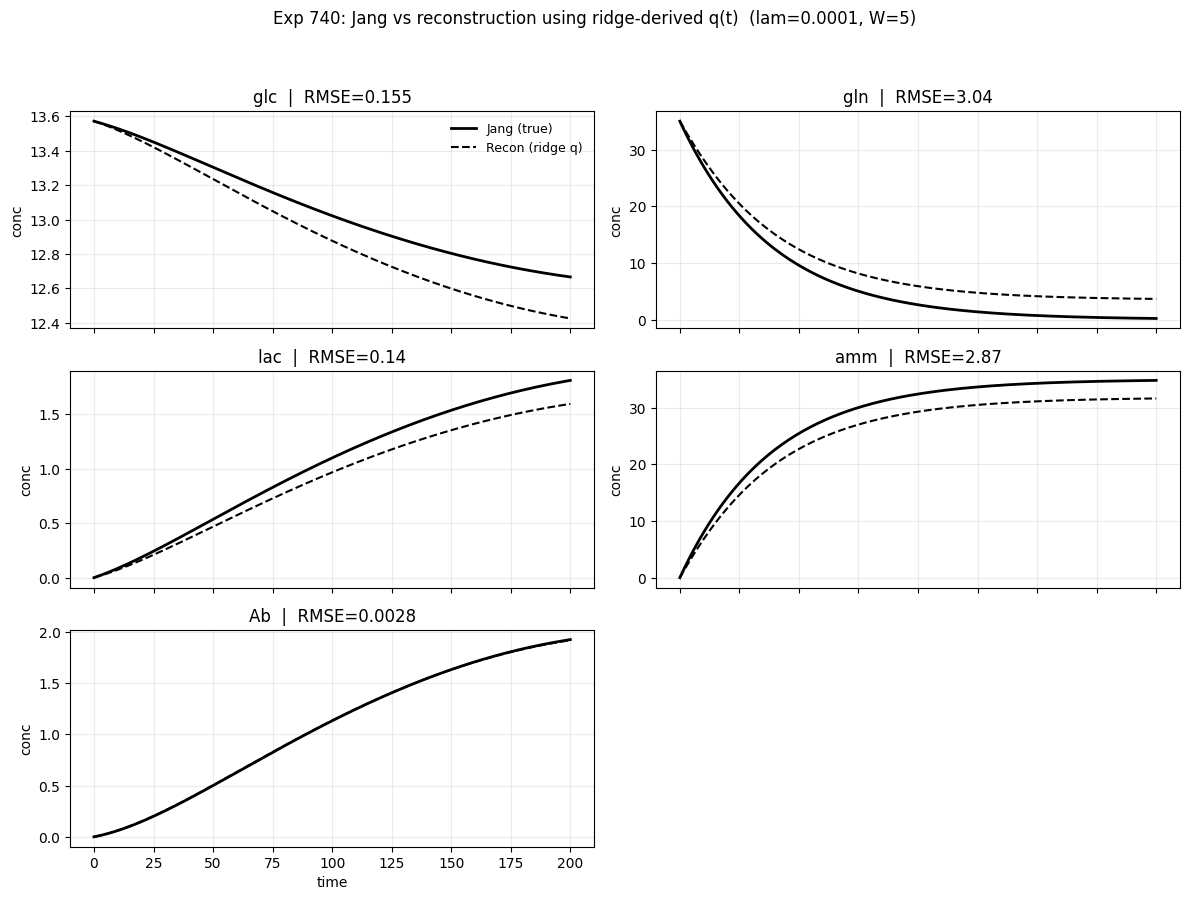

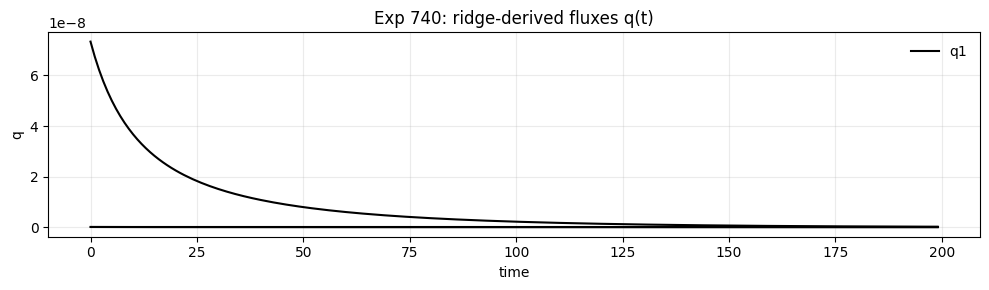

[Exp 740] RMSE per species:
   glc: 0.154821
   gln: 3.03674
   lac: 0.139622
   amm: 2.87169
    Ab: 0.00280371


In [41]:
# ============================================================
# YOU DEFINE S HERE (m x r) in the order of species_names
# ============================================================
species_names = ["glc","gln","lac","amm","Ab"]   # must match your all_C ordering

S = np.array([
    [-2.44803, -3.50990, 0.0],  # glc
    [-1.50037, -0.28841, -1],  # gln
    [ 3.40522,  0.00000, 0],  # lac
    [ 2.00074, -0.42317, 1],  # amm
    [ 0.00000,  1.00000, 0],  # Ab
], dtype=float)

# ============================================================
# Ab units handling (ONLY if your all_C[:, Ab, :] is in mg/L)
# If your trajectories already have Ab in mg/L, keep USE_AB_MG_L=True.
# If Ab is in mmol/L, set USE_AB_MG_L=False.
# ============================================================
USE_AB_MG_L = True
MW_AB_mg_per_mmol = 150_000.0
AB_ROW = species_names.index("Ab")

def apply_ab_row_scale(S_in, use_mgL):
    S_out = S_in.copy()
    if use_mgL:
        # convert Ab row from mmol/L basis to mg/L basis in the ODE dC/dt = Xv * S * q
        S_out[AB_ROW, :] *= MW_AB_mg_per_mmol
    return S_out

S_use = apply_ab_row_scale(S, USE_AB_MG_L)

# ============================================================
# Utilities: finite diff + windowed ridge q(t)
# ============================================================
def finite_diff(C, t_grid):
    dt = np.diff(t_grid)                      # (T-1,)
    return (C[:, 1:] - C[:, :-1]) / dt        # (m, T-1)

def windowed_ridge_q(Xv_vec, S_mat, dC, lam=1e-4, W=5):
    """
    Xv_vec : (T-1,)
    S_mat  : (m, r)
    dC     : (m, T-1)
    returns q: (T-1, r)
    """
    m, Tp = dC.shape
    r = S_mat.shape[1]
    I = np.eye(r)
    q = np.zeros((Tp, r), dtype=float)

    for k in range(Tp):
        kend = min(Tp, k + W)
        A_list, b_list = [], []
        for kk in range(k, kend):
            A_list.append(Xv_vec[kk] * S_mat)      # (m,r)
            b_list.append(dC[:, kk])               # (m,)
        A = np.vstack(A_list)                      # ((kend-k)*m, r)
        b = np.concatenate(b_list)                 # ((kend-k)*m,)
        q[k] = np.linalg.solve(A.T @ A + lam * I, A.T @ b)
    return q  # (T-1, r)

# ============================================================
# Reconstruct C(t) from q(t): integrate dC/dt = Xv(t) * S * q(t)
# using piecewise-linear interpolation of q and Xv on t_grid
# ============================================================
def _lin_interp_vec(ti, t_grid, y_grid):
    """
    y_grid: (T, d) or (T,) defined at t_grid.
    """
    k = np.searchsorted(t_grid, ti, side="right") - 1
    k = np.clip(k, 0, len(t_grid) - 2)
    tL, tR = t_grid[k], t_grid[k+1]
    a = 0.0 if tR == tL else (ti - tL) / (tR - tL)
    return (1.0 - a) * y_grid[k] + a * y_grid[k+1]

def _q_interp(ti, t_grid, q_grid):
    """
    q_grid: (T-1, r) defined on interval indices 0..T-2.
    We'll treat q at "time nodes" t[0..T-2] by padding last value to length T.
    """
    q_pad = np.vstack([q_grid, q_grid[-1:]])   # (T, r)
    return _lin_interp_vec(ti, t_grid, q_pad)  # (r,)

def integrate_with_q(C0, t_grid, Xv_grid, S_mat, q_grid):
    """
    C0: (m,)
    Xv_grid: (T,)
    q_grid: (T-1, r)
    returns C_hat: (m, T)
    """
    def rhs(t, C):
        Xv_t = float(_lin_interp_vec(t, t_grid, Xv_grid))
        q_t  = _q_interp(t, t_grid, q_grid)
        return (Xv_t * S_mat) @ q_t

    sol = solve_ivp(
        rhs,
        (float(t_grid[0]), float(t_grid[-1])),
        C0.astype(float),
        t_eval=t_grid.astype(float),
        method="RK45",
        rtol=1e-6,
        atol=1e-9,
    )
    return sol.y  # (m, T)

# ============================================================
# MAIN: Compare "Jang ground truth" vs "ridge-q reconstruction"
# ============================================================
def compare_ridge_reconstruction(exp_idx, lam=1e-4, W=5, plot_q=True):
    """
    Requires these globals to exist:
      all_C: (Nexp, m, T)
      all_Xv: (Nexp, T)
      t_eval: (T,)
    """
    C_true = all_C[exp_idx]         # (m,T)
    Xv     = all_Xv[exp_idx]        # (T,)
    C0     = C_true[:, 0]           # (m,)

    # ridge q from the Jang trajectory (this is your "q_ridge")
    dC = finite_diff(C_true, t_eval)                     # (m,T-1)
    q_ridge = windowed_ridge_q(Xv[:-1], S_use, dC, lam=lam, W=W)  # (T-1,r)

    # reconstruct C using q_ridge and the same Xv
    C_hat = integrate_with_q(C0, t_eval, Xv, S_use, q_ridge)      # (m,T)

    # RMSE per species in physical units
    rmse_per = np.sqrt(np.mean((C_hat - C_true)**2, axis=1))

    # --- plots: concentrations (subplots) ---
    m = C_true.shape[0]
    ncols = 2
    nrows = int(np.ceil(m / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(12, 3*nrows), sharex=True)
    axes = np.atleast_2d(axes)

    for i in range(m):
        ax = axes[i // ncols, i % ncols]
        ax.plot(t_eval, C_true[i], color="k", lw=2, label="Jang (true)" if i==0 else None)
        ax.plot(t_eval, C_hat[i],  color="k", lw=1.5, ls="--", label="Recon (ridge q)" if i==0 else None)
        ax.set_title(f"{species_names[i]}  |  RMSE={rmse_per[i]:.3g}")
        ax.set_ylabel("conc")
        ax.grid(alpha=0.25)
        if i // ncols == nrows - 1:
            ax.set_xlabel("time")

    axes[0,0].legend(frameon=False, fontsize=9)
    for j in range(m, nrows*ncols):
        fig.delaxes(axes.flatten()[j])

    fig.suptitle(f"Exp {exp_idx}: Jang vs reconstruction using ridge-derived q(t)  (lam={lam}, W={W})", y=0.995)
    fig.tight_layout(rect=[0,0,1,0.96])
    plt.show()

    # --- optional: q(t) profiles ---
    if plot_q:
        r = q_ridge.shape[1]
        fig = plt.figure(figsize=(10, 3))
        for j in range(r):
            plt.plot(t_eval[:-1], q_ridge[:, j], color="k", lw=1.5, label=f"q{j+1}" if j==0 else None)
        plt.xlabel("time")
        plt.ylabel("q")
        plt.title(f"Exp {exp_idx}: ridge-derived fluxes q(t)")
        plt.grid(alpha=0.25)
        plt.legend(frameon=False, ncol=4)
        plt.tight_layout()
        plt.show()

    print(f"[Exp {exp_idx}] RMSE per species:")
    for i, nm in enumerate(species_names):
        print(f"  {nm:>4s}: {rmse_per[i]:.6g}")

    return q_ridge, C_hat, rmse_per

# Example:
q_ridge, C_hat, rmse_per = compare_ridge_reconstruction(exp_idx=740, lam=1e-4, W=5, plot_q=True)


=== BEST ridge reconstructions (lowest overall RMSE) ===
  exp 20: RMSE=0.814769

=== WORST ridge reconstructions (highest overall RMSE) ===
  exp 1999: RMSE=3.22555


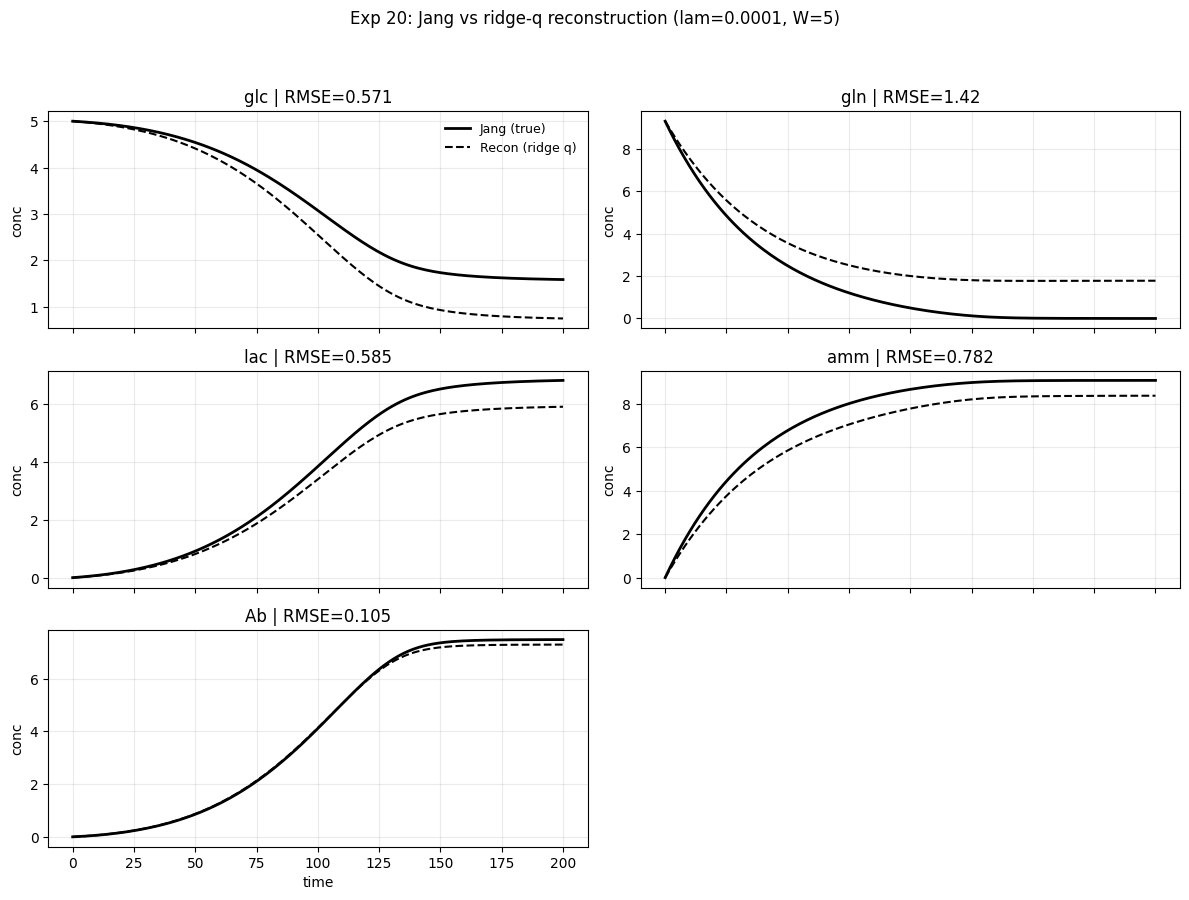

[Exp 20] overall RMSE = 0.814769
[Per-species RMSE]
   glc: 0.57052
   gln: 1.42458
   lac: 0.585276
   amm: 0.781544
    Ab: 0.104703


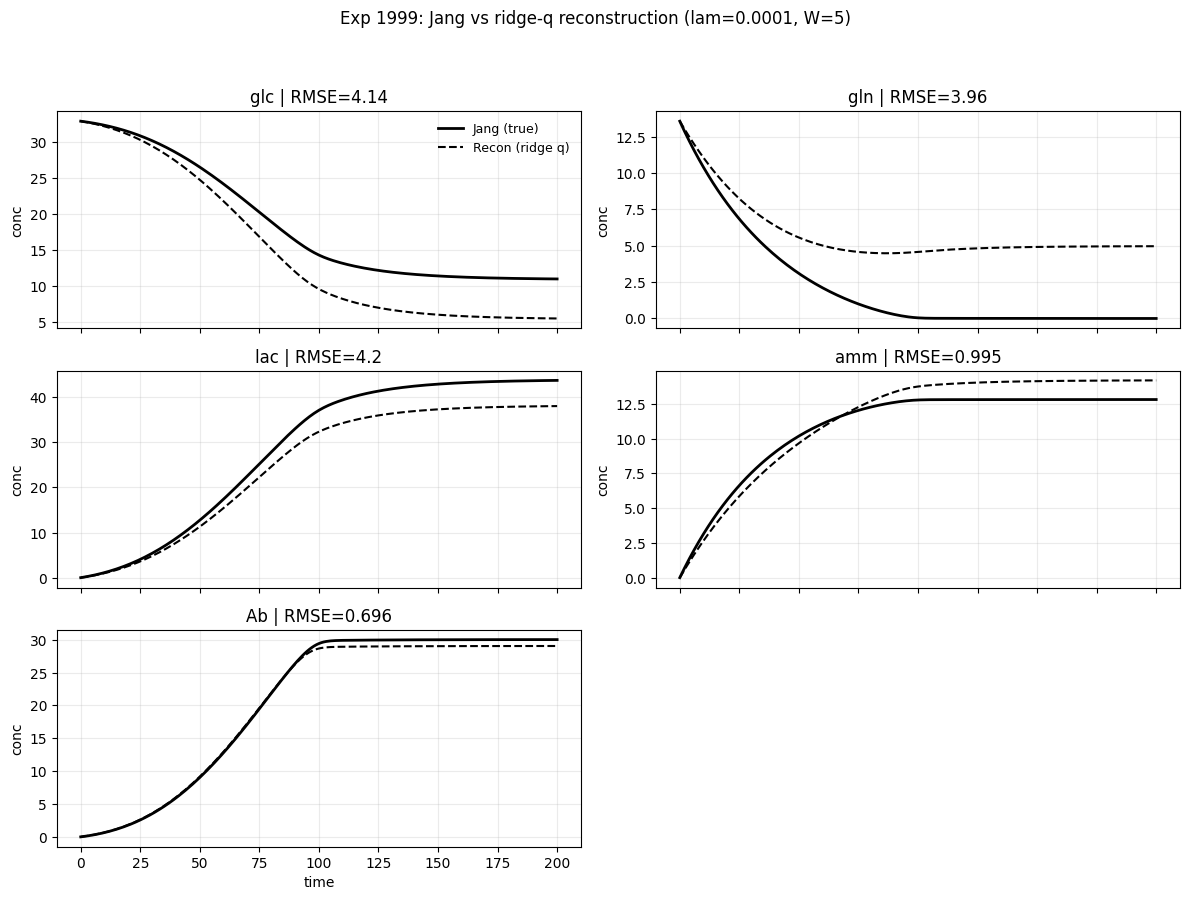

[Exp 1999] overall RMSE = 3.22555
[Per-species RMSE]
   glc: 4.14368
   gln: 3.96431
   lac: 4.20245
   amm: 0.995076
    Ab: 0.69603


In [42]:
# ------------------------------------------------------------
# Rank experiments by reconstruction RMSE (ridge-q)
# and plot top-N best + worst in black/white subplots
# ------------------------------------------------------------

def overall_recon_rmse(C_hat, C_true):
    """Single scalar RMSE over all species+time (physical units)."""
    return float(np.sqrt(np.mean((C_hat - C_true) ** 2)))

def rank_ridge_reconstructions(test_exps, lam=1e-4, W=5):
    """
    Returns:
      scores: list of (exp_id, rmse_scalar) sorted ascending
    Requires globals:
      all_C, all_Xv, t_eval, S_use
      finite_diff, windowed_ridge_q, integrate_with_q
    """
    scores = []
    for e in test_exps:
        e = int(e)
        C_true = all_C[e]
        Xv     = all_Xv[e]
        C0     = C_true[:, 0]

        dC = finite_diff(C_true, t_eval)
        q_ridge = windowed_ridge_q(Xv[:-1], S_use, dC, lam=lam, W=W)   # (T-1,r)
        C_hat   = integrate_with_q(C0, t_eval, Xv, S_use, q_ridge)     # (m,T)

        scores.append((e, overall_recon_rmse(C_hat, C_true)))

    scores.sort(key=lambda x: x[1])
    return scores

def plot_recon_triplet_for_exp(exp_id, lam=1e-4, W=5):
    """
    Plots only: Jang (true) vs Recon (ridge q) per species in subplots (B/W)
    and prints per-species RMSE.
    """
    exp_id = int(exp_id)
    C_true = all_C[exp_id]          # (m,T)
    Xv     = all_Xv[exp_id]         # (T,)
    C0     = C_true[:, 0]           # (m,)

    dC = finite_diff(C_true, t_eval)
    q_ridge = windowed_ridge_q(Xv[:-1], S_use, dC, lam=lam, W=W)       # (T-1,r)
    C_hat   = integrate_with_q(C0, t_eval, Xv, S_use, q_ridge)         # (m,T)

    rmse_per = np.sqrt(np.mean((C_hat - C_true) ** 2, axis=1))

    m = C_true.shape[0]
    ncols = 2
    nrows = int(np.ceil(m / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(12, 3*nrows), sharex=True)
    axes = np.atleast_2d(axes)

    for i in range(m):
        ax = axes[i // ncols, i % ncols]
        ax.plot(t_eval, C_true[i], color="k", lw=2, label="Jang (true)" if i==0 else None)
        ax.plot(t_eval, C_hat[i],  color="k", lw=1.5, ls="--", label="Recon (ridge q)" if i==0 else None)
        sp = species_names[i] if i < len(species_names) else f"species {i}"
        ax.set_title(f"{sp} | RMSE={rmse_per[i]:.3g}")
        ax.set_ylabel("conc")
        ax.grid(alpha=0.25)
        if i // ncols == nrows - 1:
            ax.set_xlabel("time")

    axes[0,0].legend(frameon=False, fontsize=9)
    for j in range(m, nrows*ncols):
        fig.delaxes(axes.flatten()[j])

    fig.suptitle(f"Exp {exp_id}: Jang vs ridge-q reconstruction (lam={lam}, W={W})", y=0.995)
    fig.tight_layout(rect=[0,0,1,0.96])
    plt.show()

    print(f"[Exp {exp_id}] overall RMSE = {overall_recon_rmse(C_hat, C_true):.6g}")
    print("[Per-species RMSE]")
    for i, nm in enumerate(species_names):
        print(f"  {nm:>4s}: {rmse_per[i]:.6g}")

    return C_true, C_hat, q_ridge, rmse_per

def show_best_worst_ridge_recons(test_exps, N=3, lam=1e-4, W=5):
    """
    Computes rankings on test_exps, then plots best N and worst N.
    """
    scores = rank_ridge_reconstructions(test_exps, lam=lam, W=W)

    N = int(min(N, len(scores)//2 if len(scores) >= 2 else len(scores)))
    best  = scores[:N]
    worst = scores[-N:]

    print("=== BEST ridge reconstructions (lowest overall RMSE) ===")
    for e, s in best:
        print(f"  exp {e}: RMSE={s:.6g}")

    print("\n=== WORST ridge reconstructions (highest overall RMSE) ===")
    for e, s in worst:
        print(f"  exp {e}: RMSE={s:.6g}")

    for e, s in best:
        plot_recon_triplet_for_exp(e, lam=lam, W=W)

    for e, s in worst:
        plot_recon_triplet_for_exp(e, lam=lam, W=W)

    return best, worst, scores

# Example:
best, worst, scores = show_best_worst_ridge_recons(test_exps=test_exps, N=1, lam=1e-4, W=5)


In [45]:
# ============================================================
# Per-species RMSE table (mean/std across TEST exps) for NEW S
# ============================================================

# --- 1) Define your NEW stoichiometric matrix S_new (add Gln->Amm column) ---
# Baseline 2 columns (example from your notebook):
S_base = np.array([
    [-2.44803, -3.50990, 0.0],  # glc
    [-1.50037, -0.28841, -1],  # gln
    [ 3.40522,  0.00000, 0],  # lac
    [ 2.00074, -0.42317, 1],  # amm
    [ 0.00000,  1.00000, 0],  # Ab
], dtype=float)

def windowed_ridge_q(Xv_vec, S_mat, dC, lam=1e-4, win_len=5):
    """
    Xv_vec: (T-1,)
    S_mat : (m, r)
    dC    : (m, T-1)
    returns q: (r, T-1)
    """
    m, Tp = dC.shape
    r = S_mat.shape[1]
    q = np.zeros((r, Tp), dtype=float)

    sqrt_lam = np.sqrt(lam)
    I = np.eye(r)

    for k in range(Tp):
        kend = min(Tp, k + win_len)

        A_list, b_list = [], []
        for kk in range(k, kend):
            A_list.append(Xv_vec[kk] * S_mat)   # (m,r)
            b_list.append(dC[:, kk])            # (m,)

        A = np.vstack(A_list)                   # ((kend-k)*m, r)
        b = np.concatenate(b_list)              # ((kend-k)*m,)

        # Augmented ridge system
        A_aug = np.vstack([A, sqrt_lam * I])    # ((kend-k)*m + r, r)
        b_aug = np.concatenate([b, np.zeros(r)])

        # Stable solve
        q[:, k] = np.linalg.lstsq(A_aug, b_aug, rcond=None)[0]

    return q


# Add glutamine degradation pseudo-reaction: Gln -> Amm
# Column: glc=0, gln=-1, lac=0, amm=+1, Ab=0
col_gln_deg = np.array([[0.0], [-1.0], [0.0], [1.0], [0.0]], dtype=float)

S_new = np.hstack([S, col_gln_deg])  # (m, r_new)
r_new = S_new.shape[1]
print("S_new shape:", S_new.shape)

# --- 2) Apply Ab unit scaling to S if (and only if) Ab in all_C is mg/L ---
# If you already have apply_ab_row_scale and USE_AB_MG_L defined, reuse them.
try:
    S_use_new = apply_ab_row_scale(S_new, USE_AB_MG_L)
except NameError:
    # Fallback if those names aren't defined in your notebook
    USE_AB_MG_L = True
    MW_AB_mg_per_mmol = 150_000.0
    AB_ROW = species_names.index("Ab")
    S_use_new = S_new.copy()
    if USE_AB_MG_L:
        S_use_new[AB_ROW, :] *= MW_AB_mg_per_mmol

# --- 3) Build S_tilde_new consistent with your C̃ normalization ---
# Requires C_scale already computed from all_C
S_tilde_new = np.diag(1.0 / C_scale) @ S_use_new  # (m, r_new)

# --- 4) Helper RMSE (per species) ---
def rmse_per_species(C_hat, C_true):
    # C_hat, C_true: (m, T) in physical units
    return np.sqrt(np.mean((C_hat - C_true) ** 2, axis=1))  # (m,)

def rmse_per_species_tilde(C_hat, C_true):
    # RMSE in normalized coordinates C̃ = C / C_scale (unitless, comparable across species)
    Ct = C_true / C_scale[:, None]
    Ch = C_hat  / C_scale[:, None]
    return np.sqrt(np.mean((Ch - Ct) ** 2, axis=1))  # (m,)

# --- 5) Loop over test experiments: ridge q(t) -> reconstruct -> RMSE ---
rows = []
for e in test_exps:  # assumes test_exps is your list/array of experiment indices
    e = int(e)

    C_true  = all_C[e]      # (m, T) physical
    Xv_true = all_Xv[e]     # (T,)
    C0      = C_true[:, 0]  # (m,)

    # Build dC̃/dt using C̃ and your finite_diff
    C_tilde  = C_true / C_scale[:, None]
    dC_tilde = finite_diff(C_tilde, t_eval)  # (m, T-1)

    # Identify q via windowed ridge in normalized system: dC̃/dt ≈ Xv * S̃ * q
    q_ridge_rt = windowed_ridge_q(Xv_true[:-1], S_tilde_new, dC_tilde)  # (r_new, T-1)
    q_ridge_tr = q_ridge_rt.T                                           # (T-1, r_new)

    # Reconstruct concentrations (integrate in C̃, convert back to physical inside this function)
    C_recon = integrate_with_q_tilde(C0, t_eval, Xv_true, S_tilde_new, q_ridge_tr)  # (m, T)

    rmse_phys  = rmse_per_species(C_recon, C_true)       # (m,)
    rmse_tilde = rmse_per_species_tilde(C_recon, C_true) # (m,)

    rows.append({
        "exp_id": e,
        **{f"RMSE_{species_names[i]}": float(rmse_phys[i]) for i in range(len(species_names))},
        **{f"RMSEtilde_{species_names[i]}": float(rmse_tilde[i]) for i in range(len(species_names))},
    })

df = pd.DataFrame(rows)

# --- 6) Aggregate mean/std across test experiments (per species) ---
out_rows = []
for sp in species_names:
    out_rows.append({
        "species": sp,
        "RMSE_mean": float(df[f"RMSE_{sp}"].mean()),
        "RMSE_std":  float(df[f"RMSE_{sp}"].std(ddof=1)),
        "RMSEtilde_mean": float(df[f"RMSEtilde_{sp}"].mean()),
        "RMSEtilde_std":  float(df[f"RMSEtilde_{sp}"].std(ddof=1)),
    })

df_summary = pd.DataFrame(out_rows)
display(df_summary)

# (optional) also show per-experiment table if you want
# display(df.head())


S_new shape: (5, 4)


,species,RMSE_mean,RMSE_std,RMSEtilde_mean,RMSEtilde_std
0,glc,1.319838,0.737154,0.037710,0.021062
1,gln,2.938587,0.590368,0.083960,0.016868
2,lac,2.206556,1.322403,0.049270,0.029528
3,amm,1.394646,0.734738,0.040091,0.021121
4,Ab,0.230706,0.276144,0.007356,0.008805


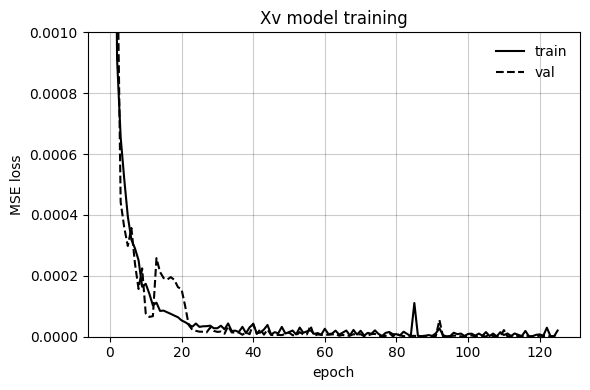

In [48]:
plt.figure(figsize=(6,4))

plt.plot(hist_q.history["loss"],
         color="black", linestyle="-", linewidth=1.5, label="train")
plt.plot(hist_q.history["val_loss"],
         color="black", linestyle="--", linewidth=1.5, label="val")

plt.xlabel("epoch")
plt.ylabel("MSE loss")
plt.title("Xv model training")
plt.ylim(top=0.001, bottom=0)
plt.legend(frameon=False)
plt.grid(True, color="black", alpha=0.2)
plt.tight_layout()
plt.show()
